<a href="https://colab.research.google.com/github/maxenlee/Deep-Dive/blob/main/Maxen_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 – Regression machine learning to predict housing prices



## Problem Definition

Given a record of home sales, Can we predict a sale price of a home using a regression analysis?

## Dependencies
Installing dependencies and modules


In [27]:
#for reading pdf
!pip install pymupdf
#Personal ToolBox
!git clone https://github.com/maxenlee/DataScienceToolBox
# Install the required package for fuzzy string matching
!pip install fuzzywuzzy


fatal: destination path 'DataScienceToolBox' already exists and is not an empty directory.


In [28]:
#Toolbox
import sys
sys.path.append('/content/DataScienceToolBox')
from ToolBox import DataFrameAnalyzer
#there will be an warning
import numpy as np
import pandas as pd
#visualizations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#Model Fitting and featue selection
from sklearn import datasets
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Model performance comparison and analyzation
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report
)
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
#for reading pdf
import fitz  # PyMuPDF for handling PDF files
import re  # Regular expressions for pattern matching
from fuzzywuzzy import process  # Fuzzy string matching
import requests

## Data Collection



### Housing Data
Data sourced from course material:
[Housing Data](https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing.Data.csv)


In [29]:
df = pd.DataFrame(pd.read_csv('https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing.Data.csv'))
columns = list(df.columns)
df.head()


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


### Dictionary
To further understand the data: [Data Dictionary](https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing.Data.csv)

In [30]:
# Load your DataFrame here (replace 'your_dataframe.csv' with your actual file)
# df = pd.read_csv("your_dataframe.csv")
pdf_url = "https://cnmi-cohort-13-stuff.sfo3.digitaloceanspaces.com/Housing%20-%20Data%20Documentation.pdf"
memory = requests.get(pdf_url)

 # Open the PDF document containing data documentation
doc = fitz.open(stream = memory.content,filetype='pdf')


## Data Cleaning

Trying two ways to work with the data

1. Import the data dictionary and split the data in their respective types.(nominal, ordinal, discrete, continuous)

1. Only use the numerical data in the dataset. Anything that is a integer or float



### Cleaning Data Dictionary

In [31]:
# Read text from each page of the PDF document
text_from_pdf = ""
for page in doc:
    text_from_pdf += page.get_text()

# Define patterns to identify variable names and their types (Nominal, Continuous, etc.)
variable_patterns = {
    "Nominal": r"\n(.*?)\s*\((Nominal)\):",
    "Continuous": r"\n(.*?)\s*\((Continuous)\):",
    "Ordinal": r"\n(.*?)\s*\((Ordinal)\):",
    "Discrete": r"\n(.*?)\s*\((Discrete)\):"
}

# Extract variable names based on their types
extracted_variables = {}
for var_type, pattern in variable_patterns.items():
    found_variables = re.findall(pattern, text_from_pdf, re.IGNORECASE)
    extracted_variables[var_type] = [var[0].strip() for var in found_variables]

# Function to perform fuzzy matching of extracted variable names against DataFrame columns
def match_columns_to_types(dataframe, extracted_vars, match_threshold=60):
    column_matches = {var_type: [] for var_type in extracted_vars}
    for column in dataframe.columns:
        for var_type, variables in extracted_vars.items():
            best_match, match_score = process.extractOne(column, variables)
            if match_score >= match_threshold:
                column_matches[var_type].append(column)
                break  # Stop if the best match is found for a category
    return column_matches

# Fuzzy match DataFrame columns to extracted variable types
matched_columns_to_types = match_columns_to_types(df, extracted_variables, 60)

# Split the original DataFrame into separate DataFrames for each variable type
dfs_by_type = {var_type: df[matched_columns] for var_type, matched_columns in matched_columns_to_types.items() if matched_columns}

# Now, dataframes_by_type contains separate DataFrames categorized by variable type

In [51]:
#we have 4 data frames
for i in dfs_by_type:
  print(i, dfs_by_type[i].shape)

Nominal (2637, 43)
Continuous (2637, 17)
Ordinal (2637, 13)
Discrete (2637, 8)


#### Data Dictionary Cleaning Issue
The import and regex interpretation of the data dictionary successfully split the original dataset into seperate data sets.

The issue stems from the fact that the datatypes in some of the columns are not immediatley interpreted as the same type respresented in the dictionary. It will take some work to get the data to fit the model.

Before taking on this next step let's explore another option to get us towards an insight sooner.

In [33]:
#Numerical data shoould all be ints or floats
for i in dfs_by_type:
  print('DataFrame',i)
  print(dfs_by_type[i].dtypes.value_counts())
  print()

DataFrame Nominal
object     32
int64       6
float64     5
dtype: int64

DataFrame Continuous
int64      10
float64     4
object      3
dtype: int64

DataFrame Ordinal
object     8
int64      3
float64    2
dtype: int64

DataFrame Discrete
int64    8
dtype: int64



### Data Cleaning option two
Cleaning the data with only numerical numbers



In [34]:
# get all the numerical data in one simple line
df_numerical = df.select_dtypes(exclude = ['object'])
df_numerical.dtypes.value_counts()

int64      27
float64    11
dtype: int64

### Numerical data nulls
Finding nulls and dropping columns based on threshold and dropping rows if under threshold



In [35]:
df_numerical.isna().sum().sort_values()

PID                  0
Mo Sold              0
Misc Val             0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Bedroom AbvGr        0
Half Bath            0
Full Bath            0
Yr Sold              0
SalePrice            0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
MS SubClass          0
Gr Liv Area          0
Lot Area             0
Year Remod/Add       0
Year Built           0
Overall Cond         0
Overall Qual         0
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Cars          1
Bsmt Full Bath       2
Bsmt Half Bath       2
Mas Vnr Area        23
Garage Yr Blt      147
Lot Frontage       449
dtype: int64

In [36]:
# Identify columns with more than 100 null values
columns_to_drop = df_numerical.columns[df_numerical.isnull().sum() > 100]

# Drop these columns from the DataFrame
df_numerical = df_numerical.drop(columns=columns_to_drop)
# Drop remaining rows
df_numerical.dropna(inplace=True)
# display nulls
df_numerical.isna().sum()

PID                0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

### UID check
Looking to see if there are any unique identifiers in the set.

In [37]:
UID_Drop = df_numerical.columns[df_numerical.nunique() == df_numerical.shape[0]]
df_numerical.drop(columns = UID_Drop,inplace = True)
print(df_numerical.shape[0], 'Rows')
df_numerical.nunique().sort_values(ascending=False)

2611 Rows


Lot Area           1782
Gr Liv Area        1206
Bsmt Unf SF        1076
1st Flr SF         1015
Total Bsmt SF       994
SalePrice           969
BsmtFin SF 1        930
2nd Flr SF          585
Garage Area         574
Mas Vnr Area        425
Wood Deck SF        367
BsmtFin SF 2        252
Open Porch SF       236
Enclosed Porch      174
Year Built          118
Screen Porch        115
Year Remod/Add       61
Misc Val             35
Low Qual Fin SF      31
3Ssn Porch           26
MS SubClass          16
TotRms AbvGrd        12
Pool Area            12
Mo Sold              12
Overall Qual         10
Overall Cond          9
Bedroom AbvGr         7
Garage Cars           6
Fireplaces            5
Yr Sold               5
Full Bath             5
Kitchen AbvGr         4
Bsmt Full Bath        4
Half Bath             3
Bsmt Half Bath        3
dtype: int64

## Exploratory Data Analysis



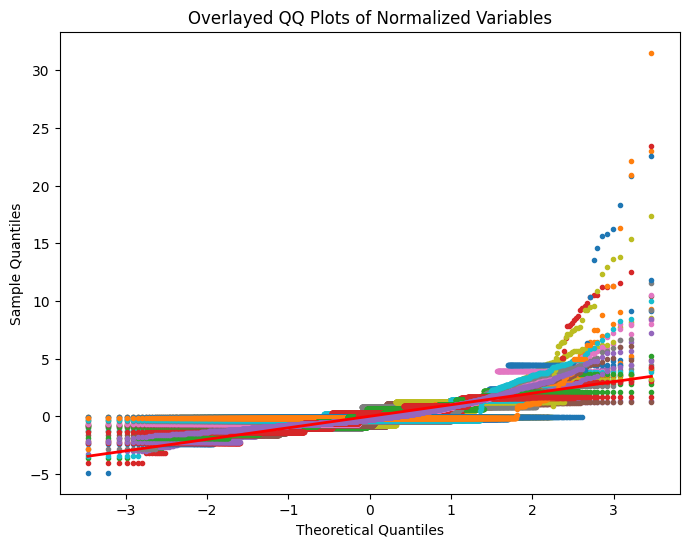

In [38]:
df_features = df_numerical
# Normalize each column in the DataFrame
normalized_df = (df_features - df_features.mean()) / df_features.std()

# Prepare the plot
plt.figure(figsize=(8, 6))

# Generate QQ plots for each normalized variable
for column in normalized_df:
    # Generate theoretical quantiles and sample quantiles
    (osm, osr), (slope, intercept, r) = stats.probplot(normalized_df[column], dist="norm")

    # Plot the sample quantiles against the theoretical quantiles
    plt.plot(osm, osr, marker='o', linestyle='', ms=3, label=column)

# Plot the line y = x, which represents a perfect match with the normal distribution
plt.plot([np.min(osm), np.max(osm)], [np.min(osm), np.max(osm)], 'r-', lw=2)

# plt.legend()
plt.title('Overlayed QQ Plots of Normalized Variables')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


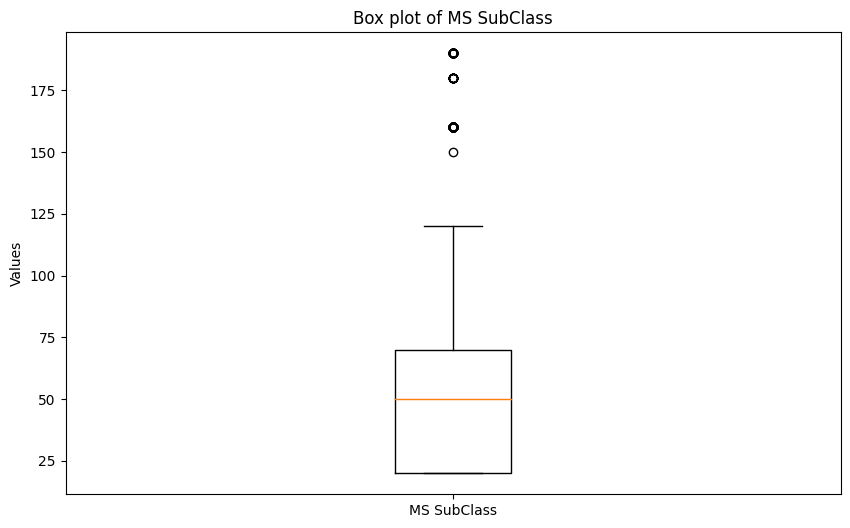

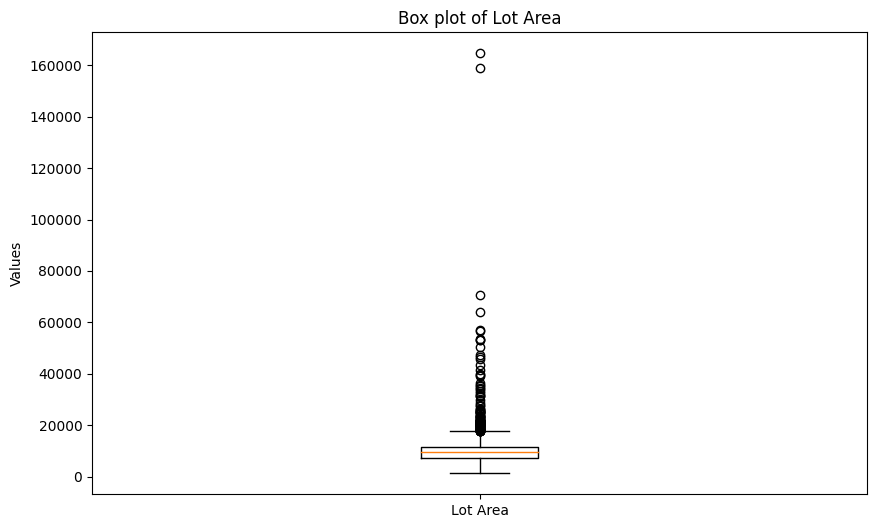

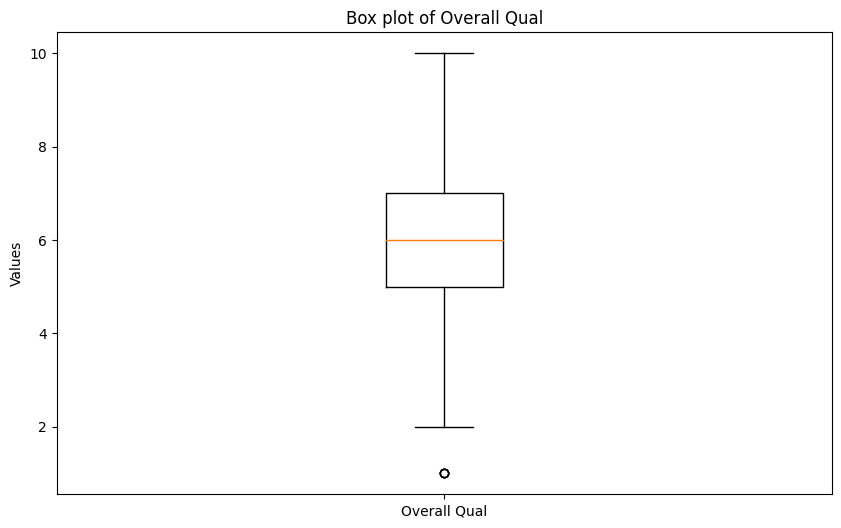

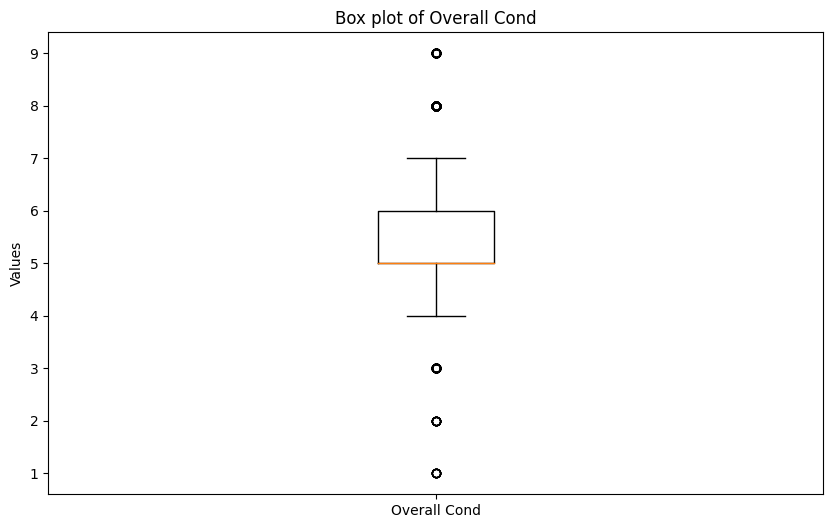

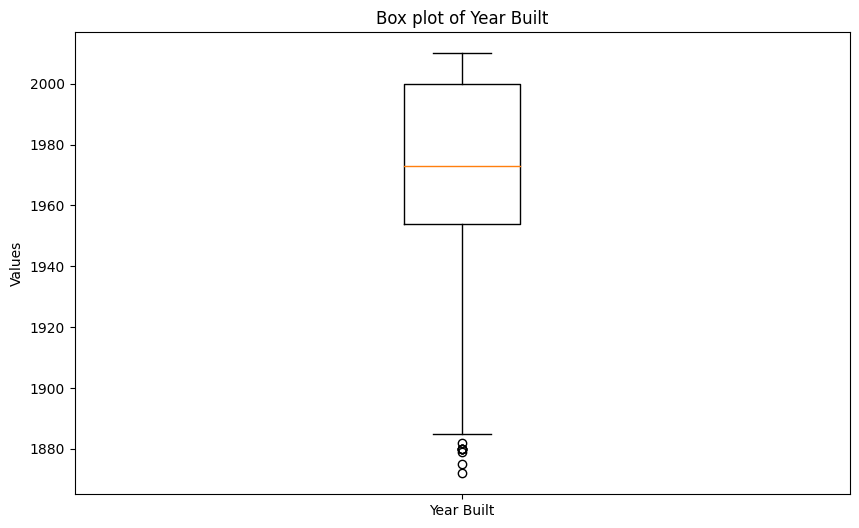

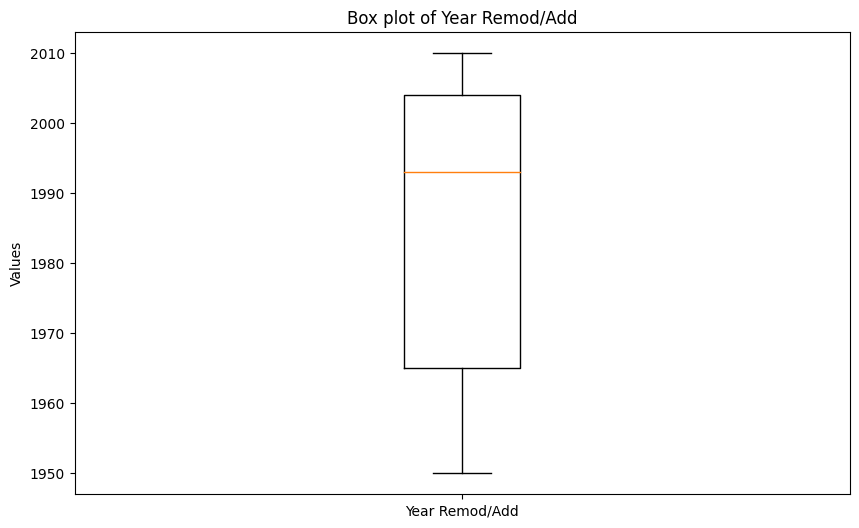

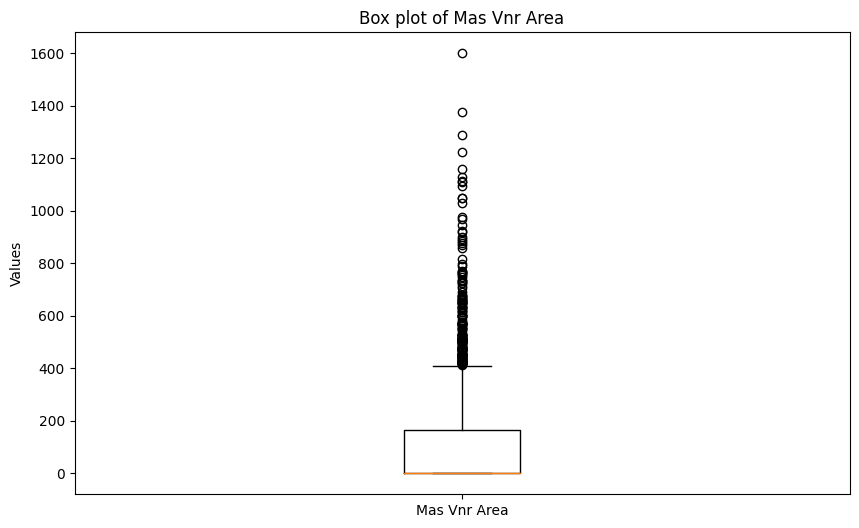

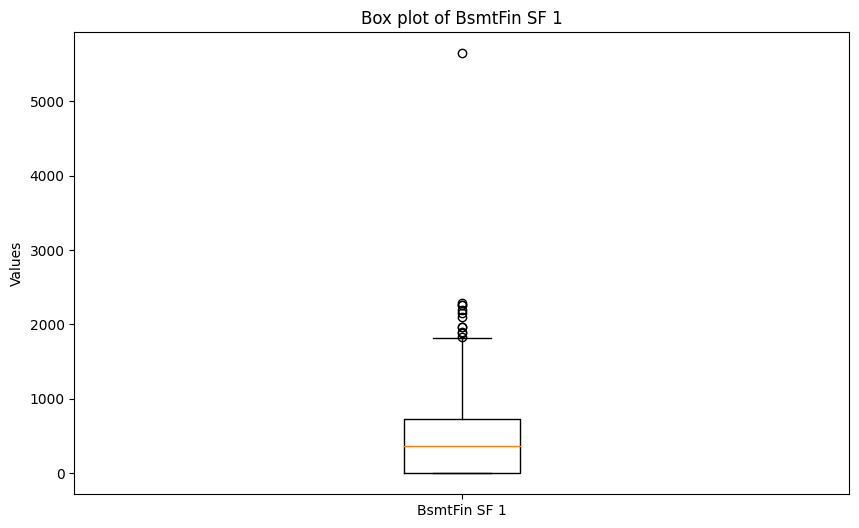

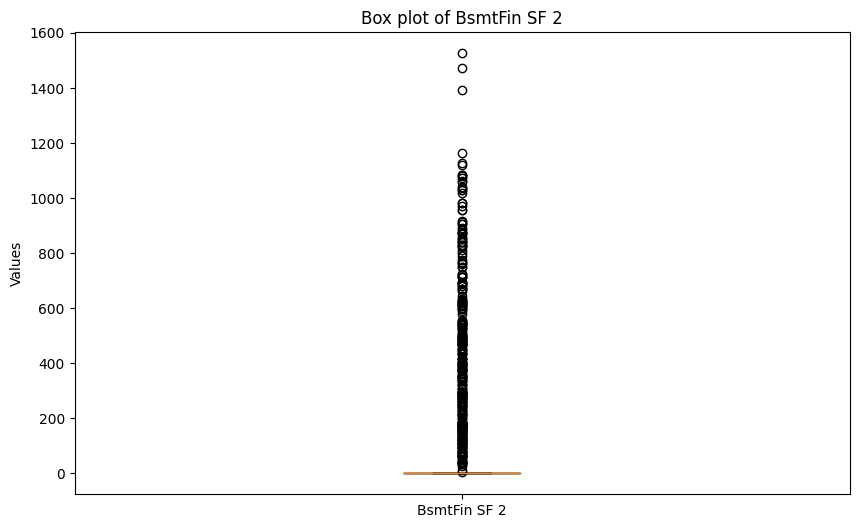

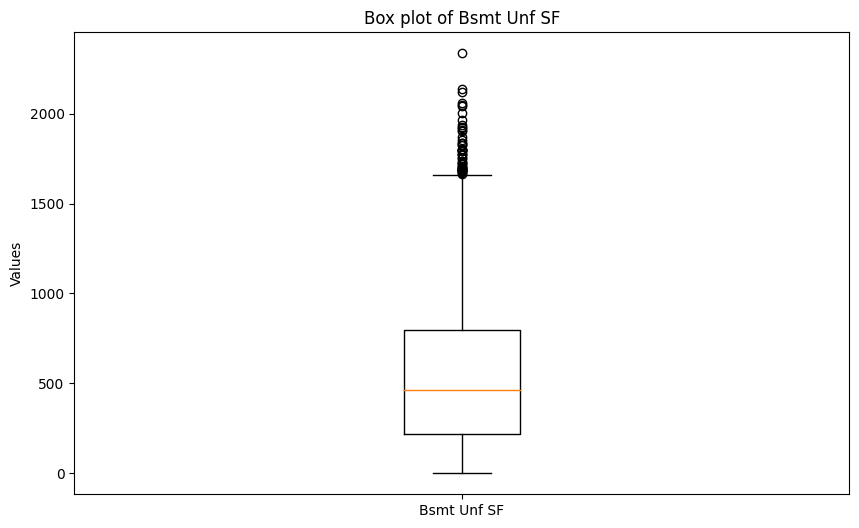

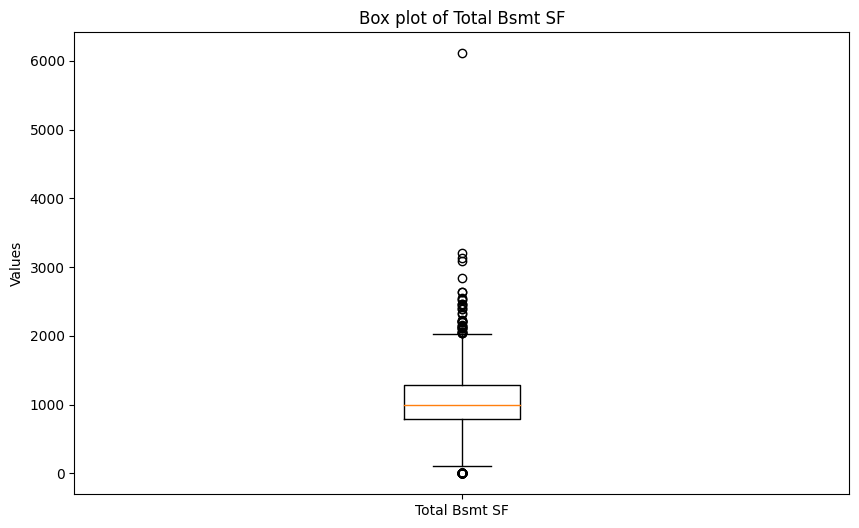

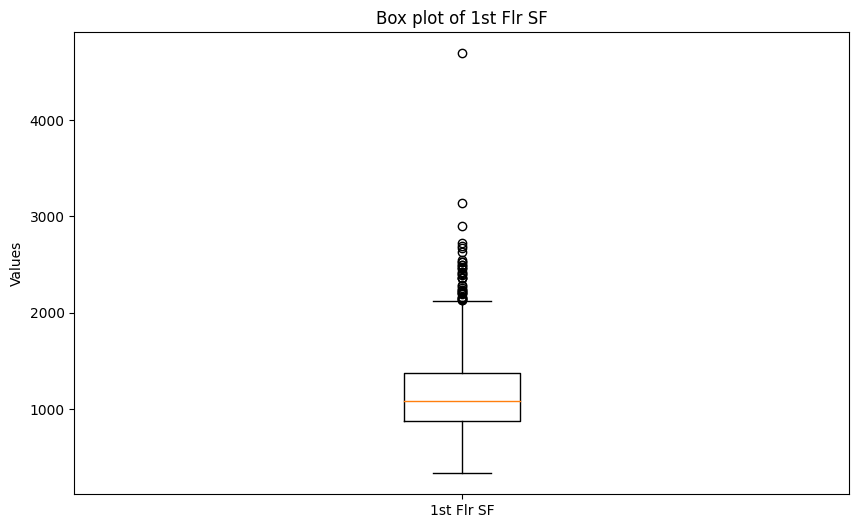

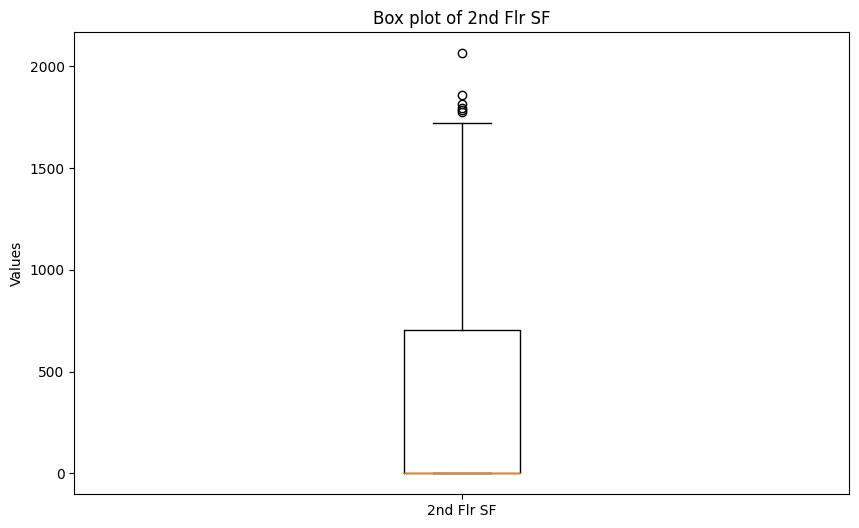

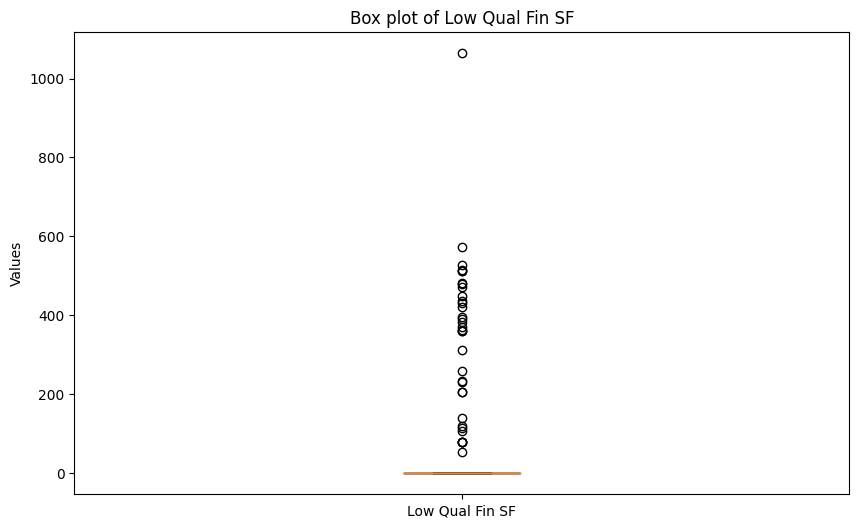

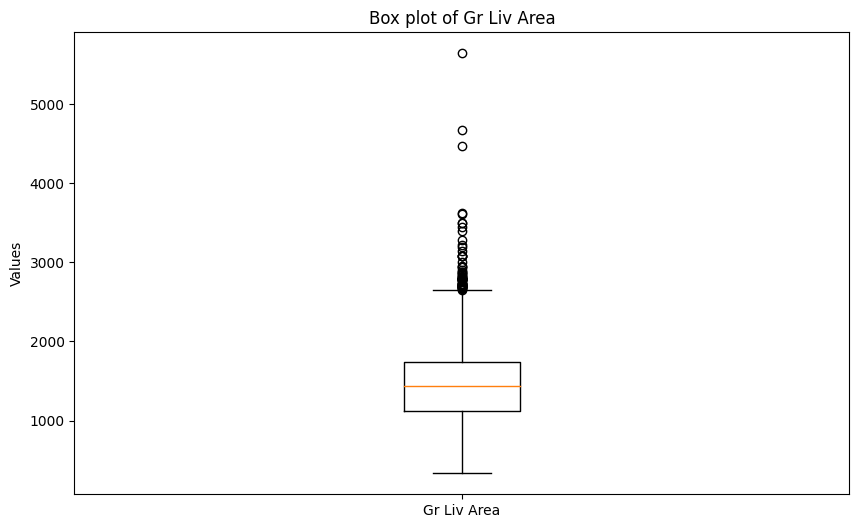

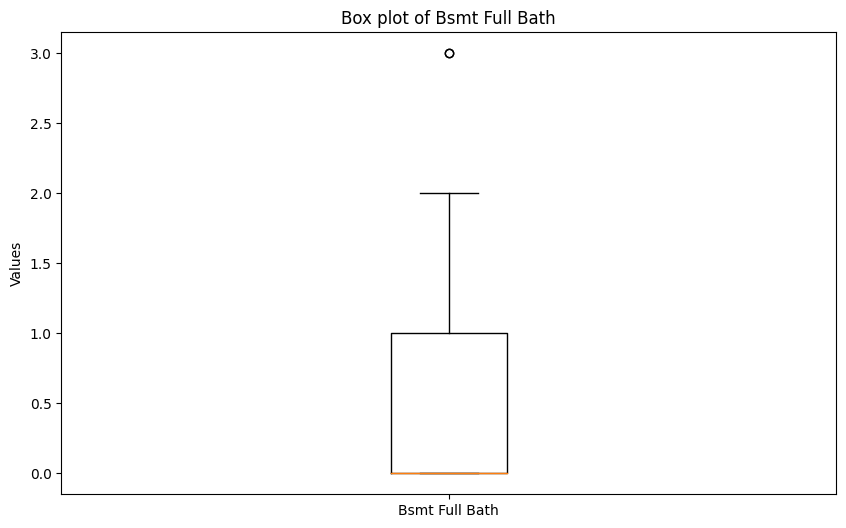

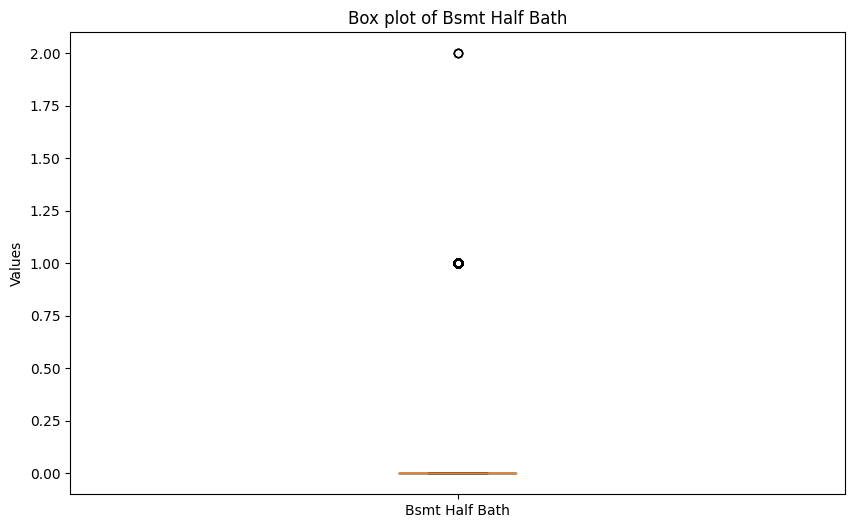

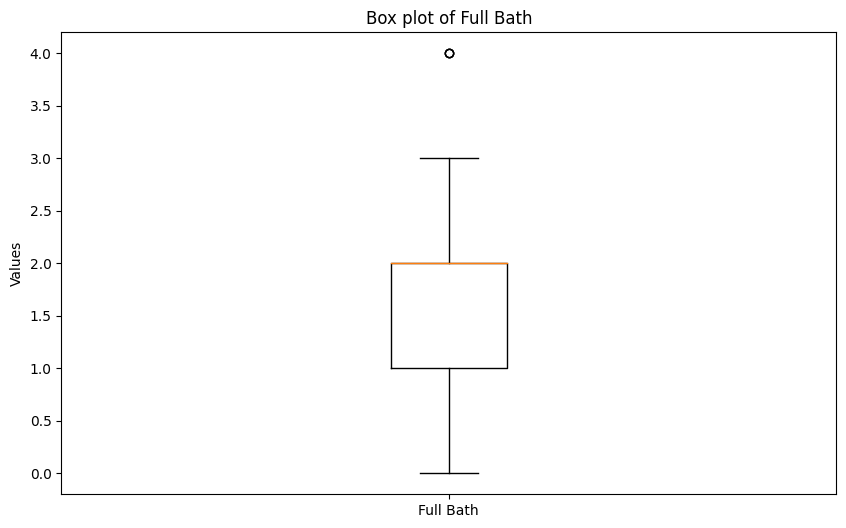

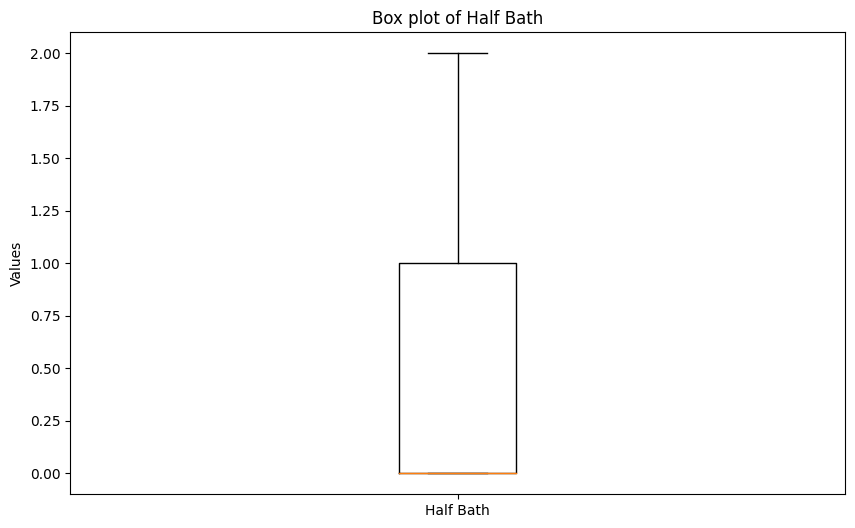

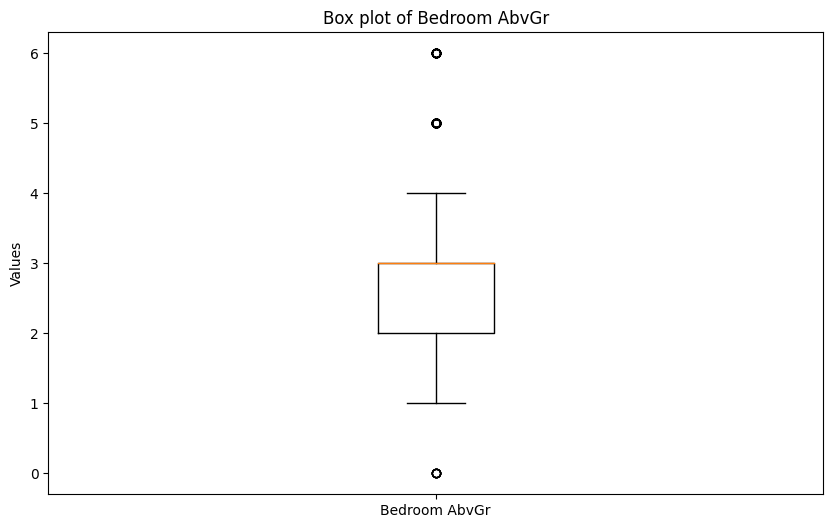

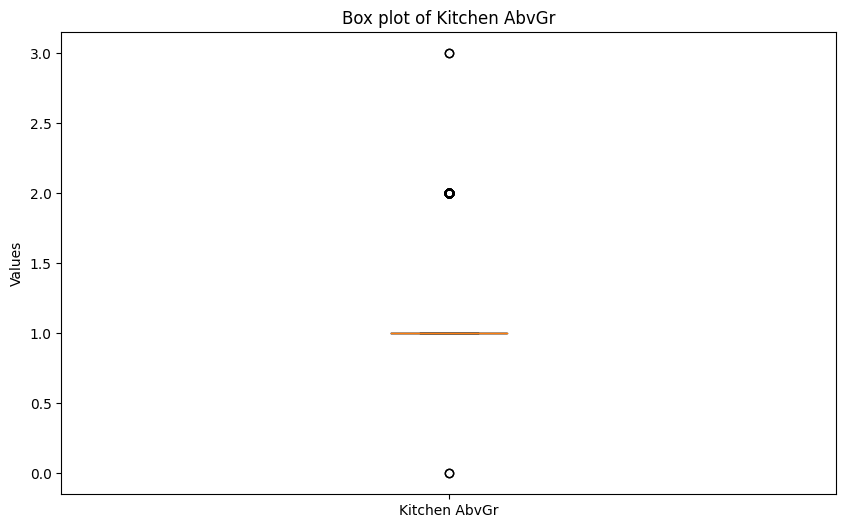

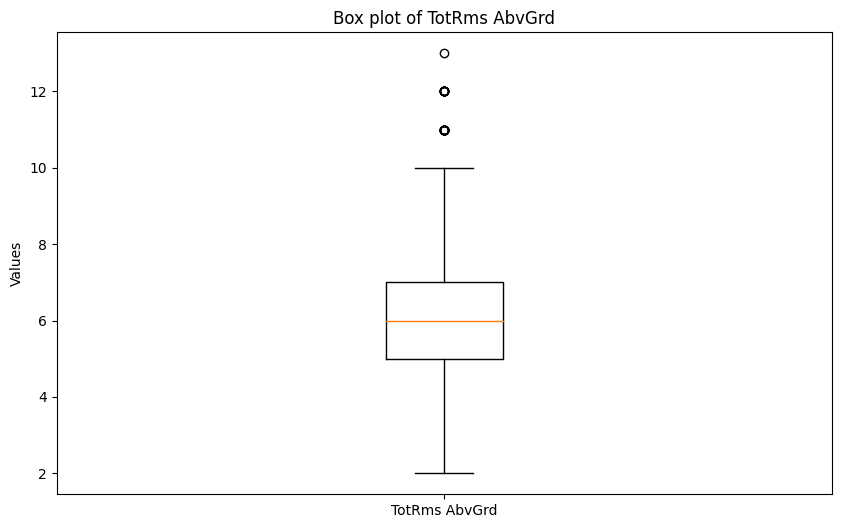

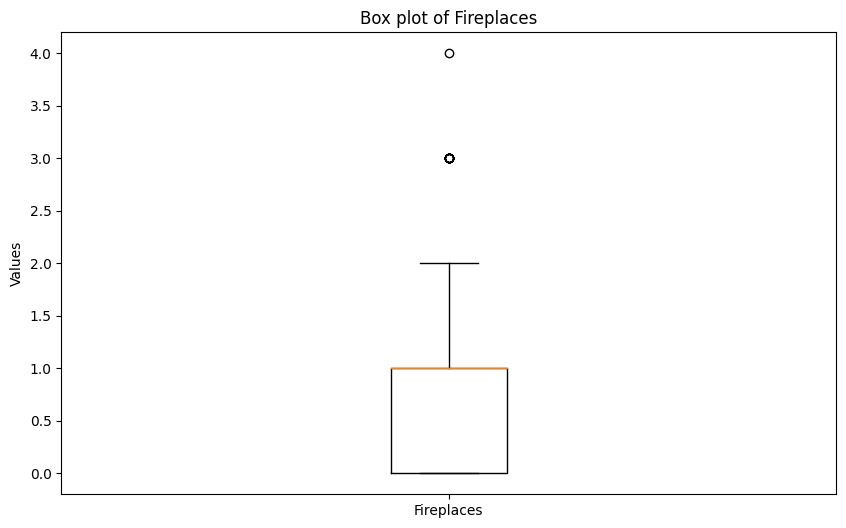

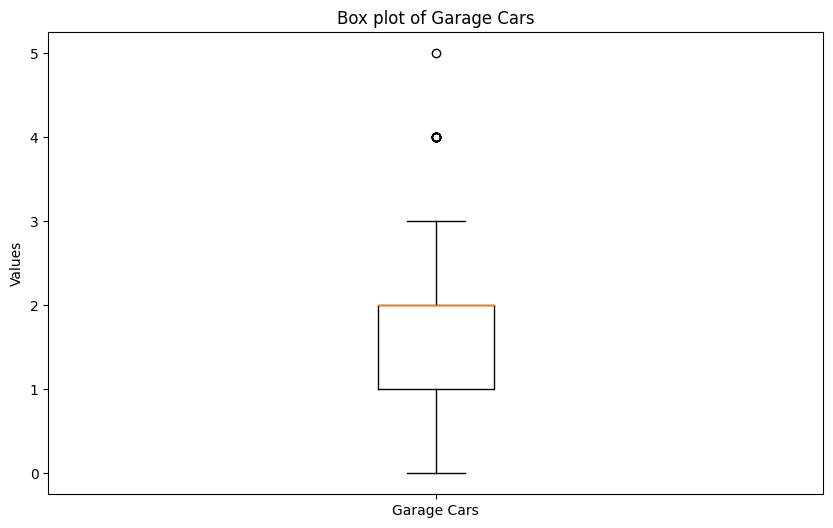

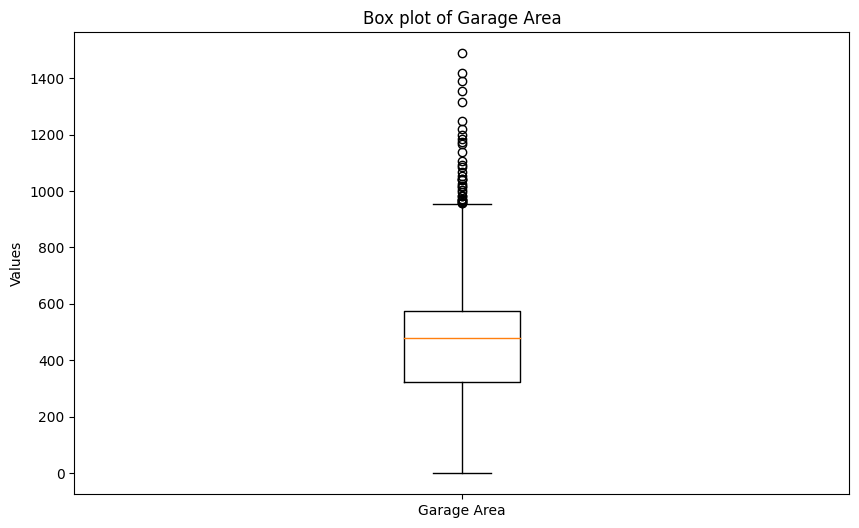

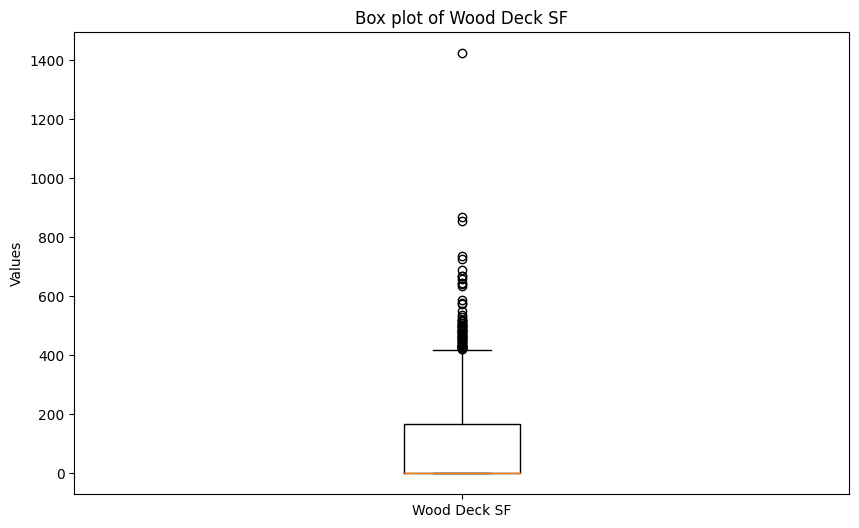

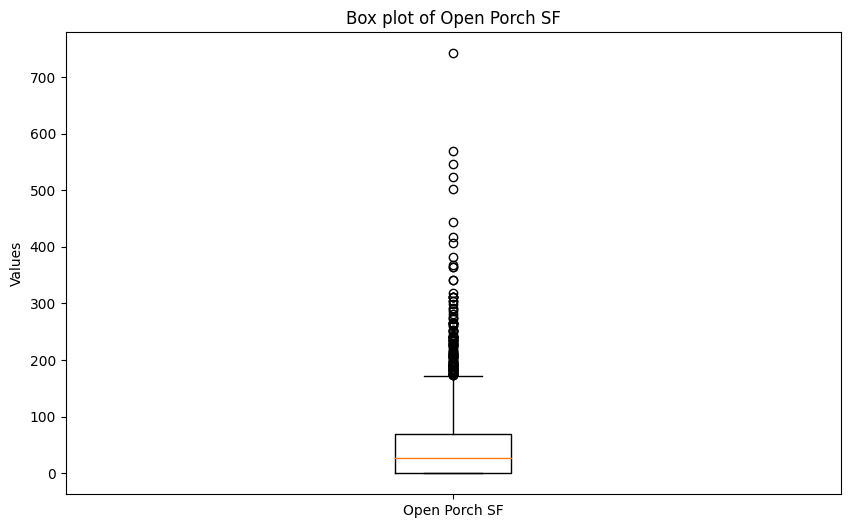

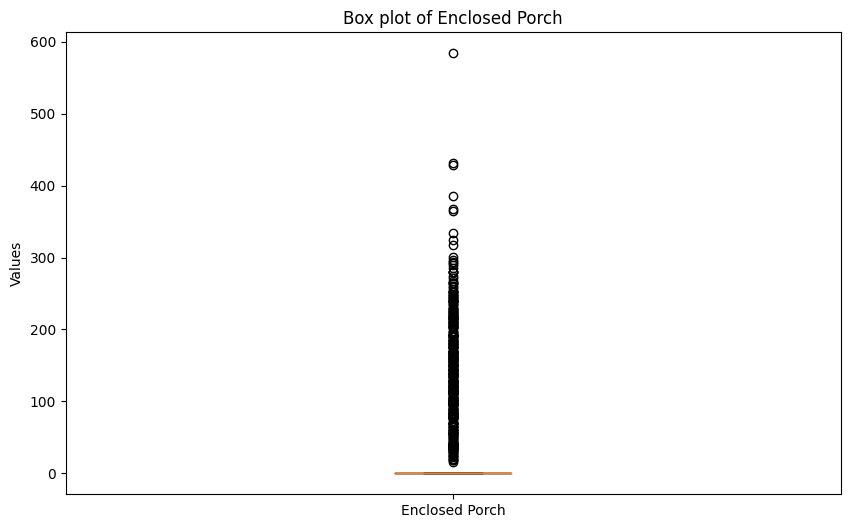

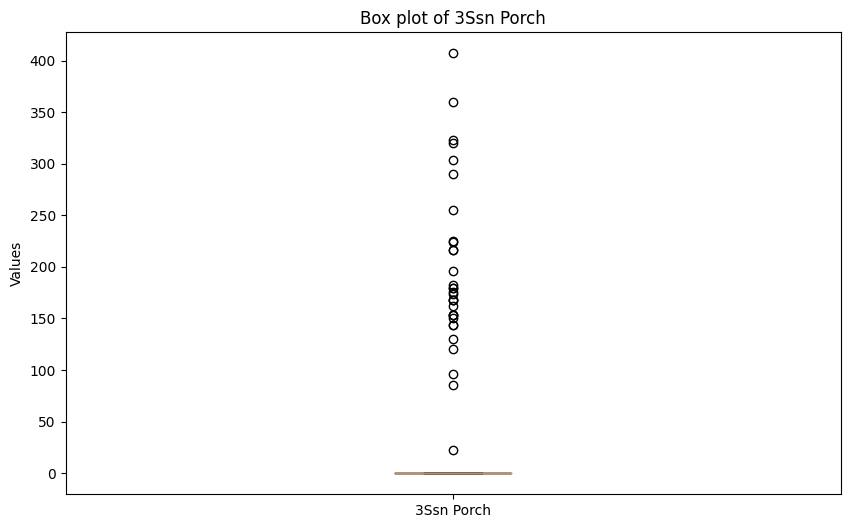

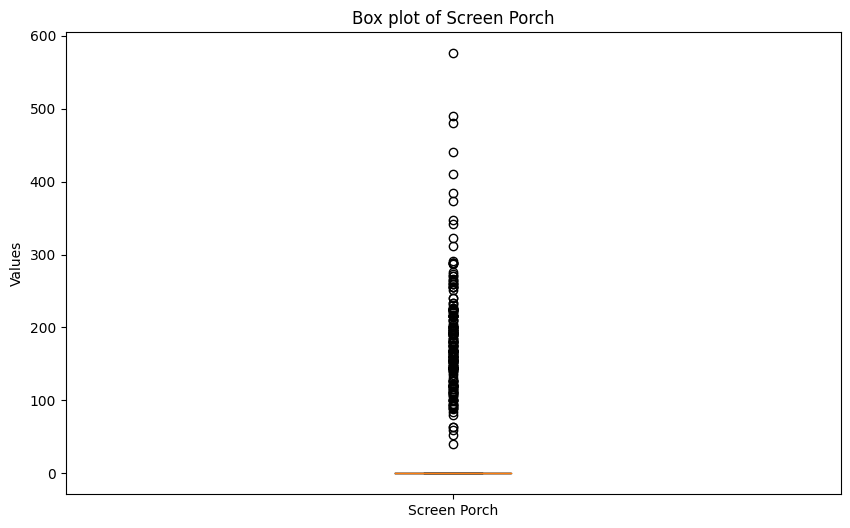

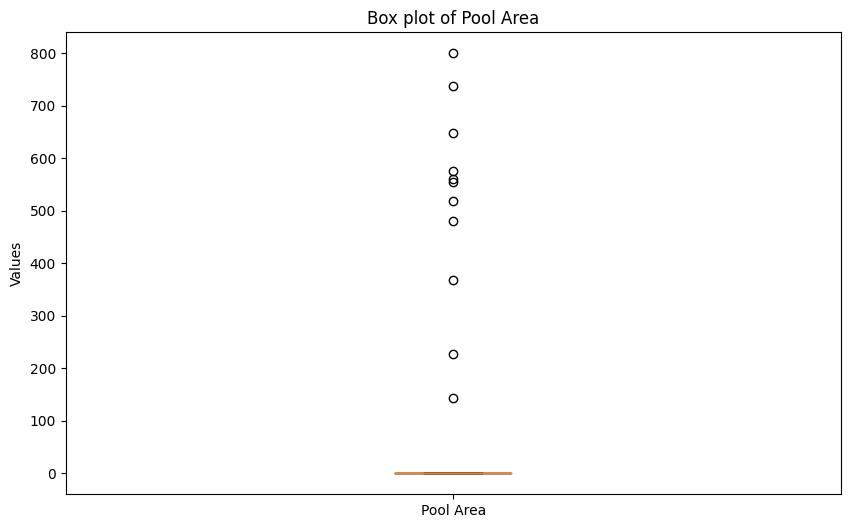

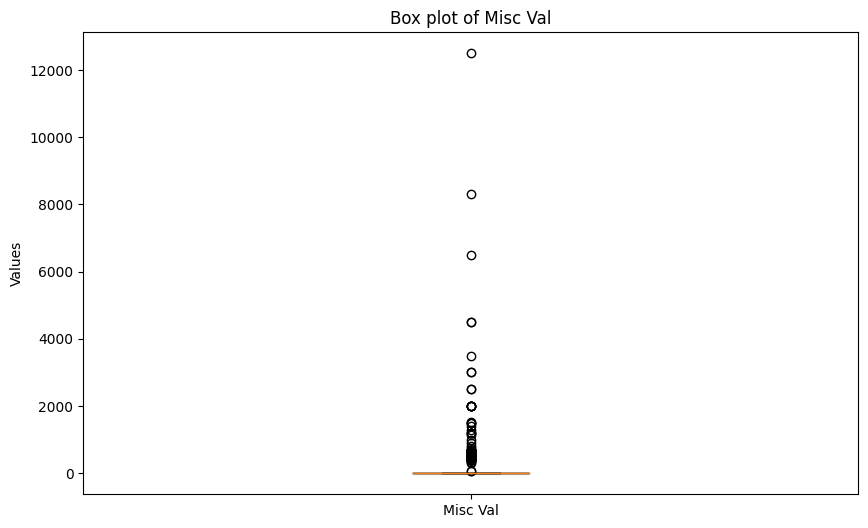

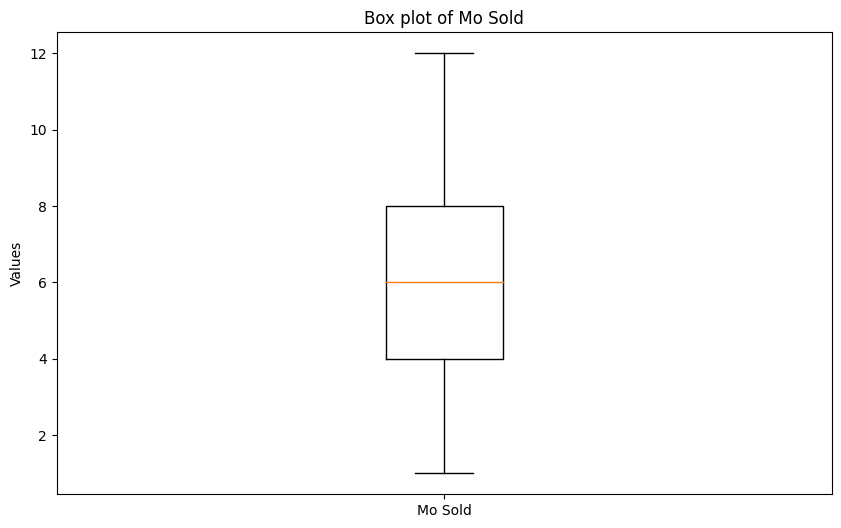

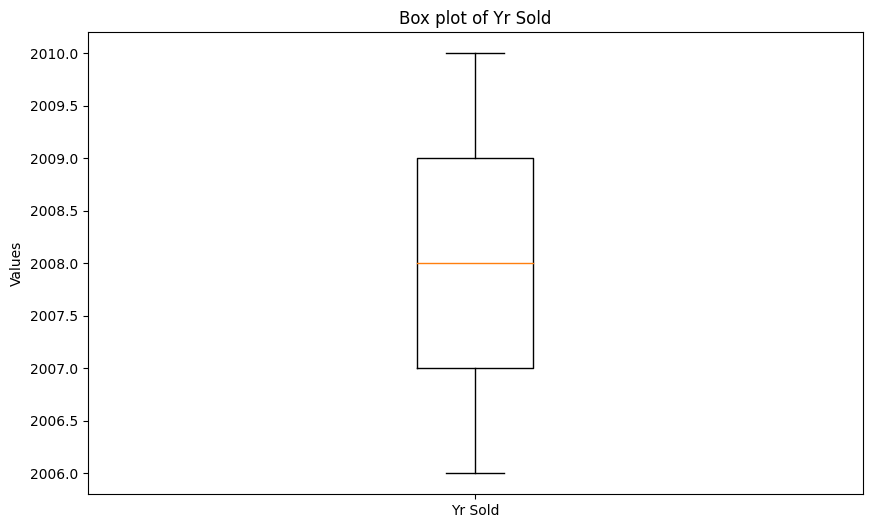

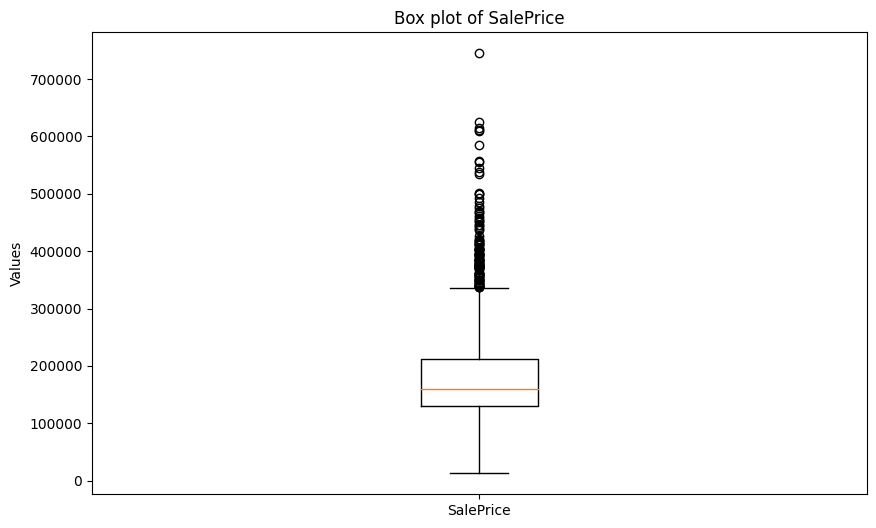

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation
# df = pd.DataFrame({
#     'feature_name': [...],  # Your data here
# })

# Creating a box plot
for i in df_numerical:
  plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
  plt.boxplot(df_numerical[i])
  plt.title(f'Box plot of {i}')
  plt.ylabel('Values')
  plt.xticks([1], [i])  # Adjust x-ticks if plotting multiple features

  plt.show()

In [40]:
def outlier_bounds(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Applying the outlier_bounds function to each numerical column in the DataFrame
bounds = {col: outlier_bounds(df_numerical[col]) for col in df_numerical.select_dtypes(include=[np.number]).columns}

# Filtering the DataFrame to remove outliers in any numerical column
filtered_df_numerical = df_numerical.copy()
for col, (lower_bound, upper_bound) in bounds.items():
    filtered_df_numerical = filtered_df_numerical[(filtered_df_numerical[col] >= lower_bound) & (filtered_df_numerical[col] <= upper_bound)]



In [41]:
filtered_df_numerical


,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
5,20,8521,5,5,1967,1967,0.0,842.0,0.0,70.0,...,0,0,0,0,0,0,0,5,2010,125000
6,20,7314,7,5,2007,2007,82.0,724.0,0.0,508.0,...,132,0,0,0,0,0,0,2,2009,194500
10,20,9196,7,5,2003,2003,0.0,0.0,0.0,1560.0,...,100,150,0,0,0,0,0,4,2010,201000
11,120,6289,6,5,2005,2006,256.0,762.0,0.0,600.0,...,192,28,0,0,0,0,0,6,2007,207000
12,60,10005,7,5,1977,1977,299.0,392.0,0.0,768.0,...,288,117,0,0,0,0,0,3,2008,192000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628,60,9375,7,5,1997,1997,0.0,0.0,0.0,1040.0,...,331,38,0,0,0,0,0,4,2010,240000
2629,70,6720,6,7,1921,1950,0.0,0.0,0.0,585.0,...,184,0,0,0,0,0,0,4,2007,141500
2634,120,3782,8,5,1981,1981,0.0,960.0,0.0,266.0,...,133,78,0,0,0,0,0,9,2009,211500
2635,20,10140,6,5,1974,1974,174.0,0.0,0.0,1064.0,...,0,0,0,0,0,0,0,8,2009,165000


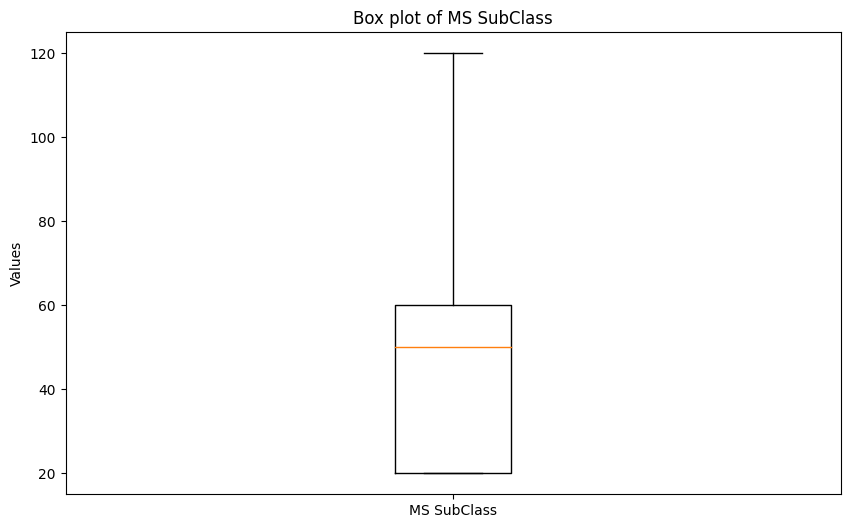

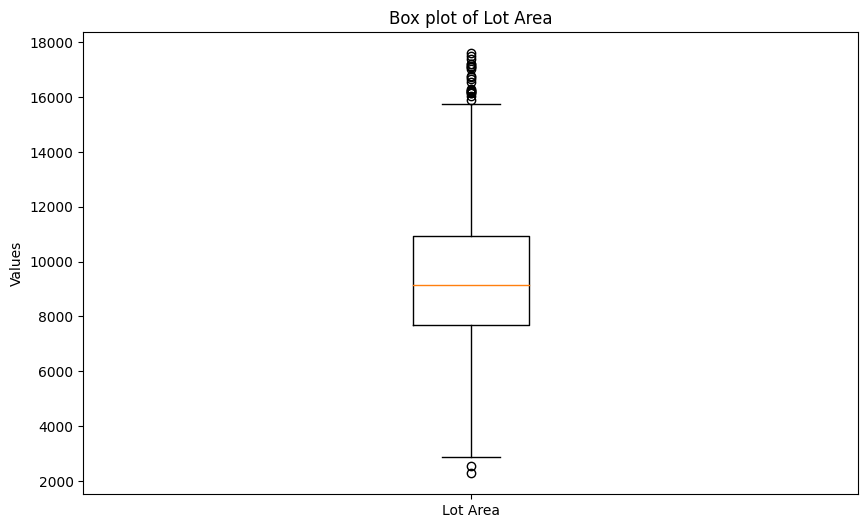

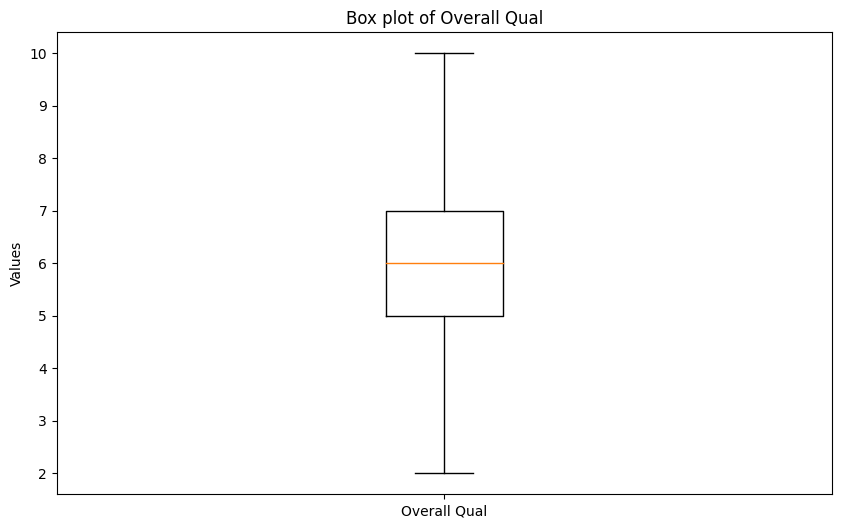

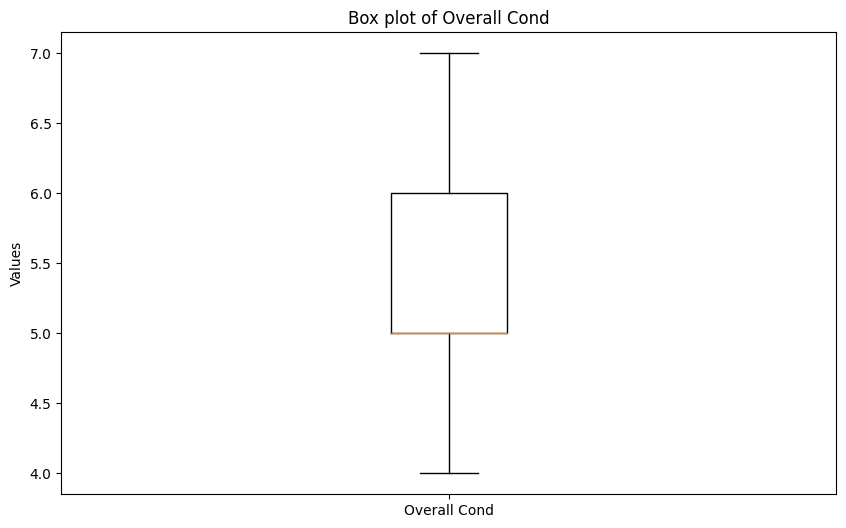

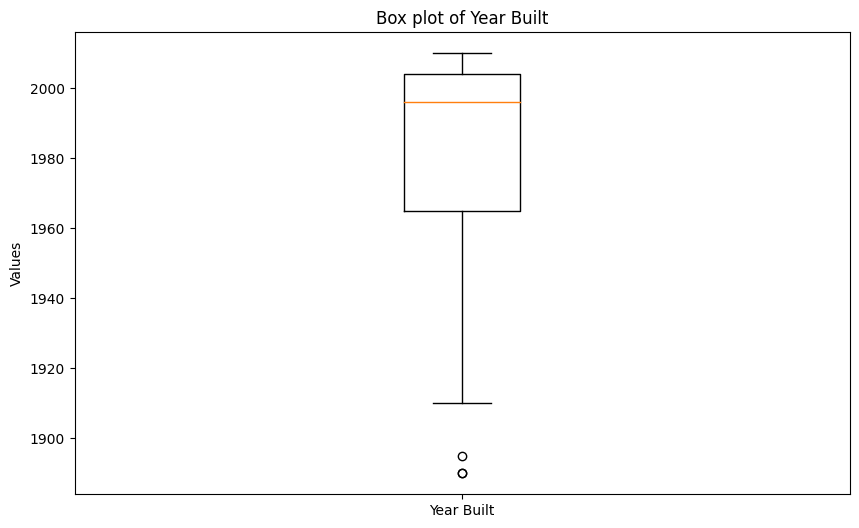

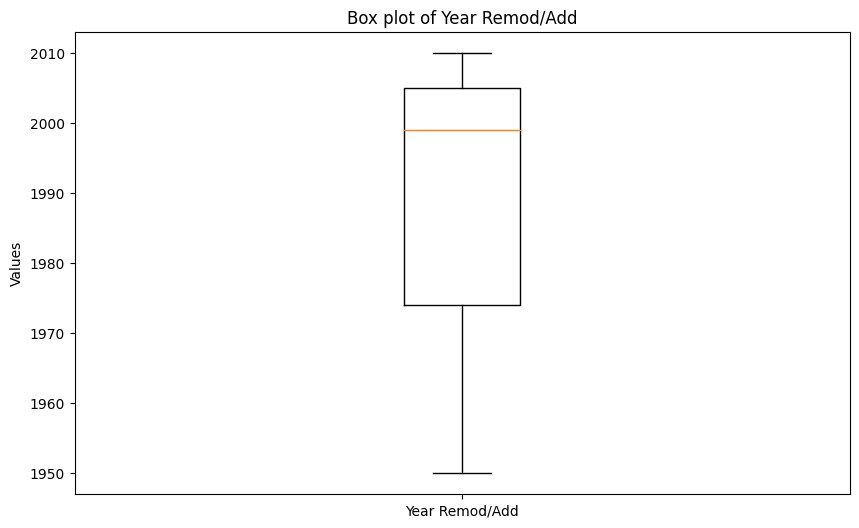

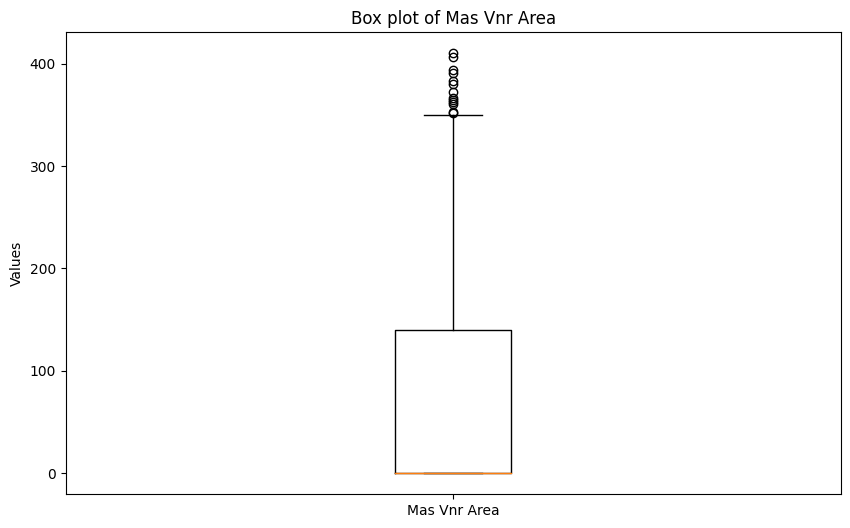

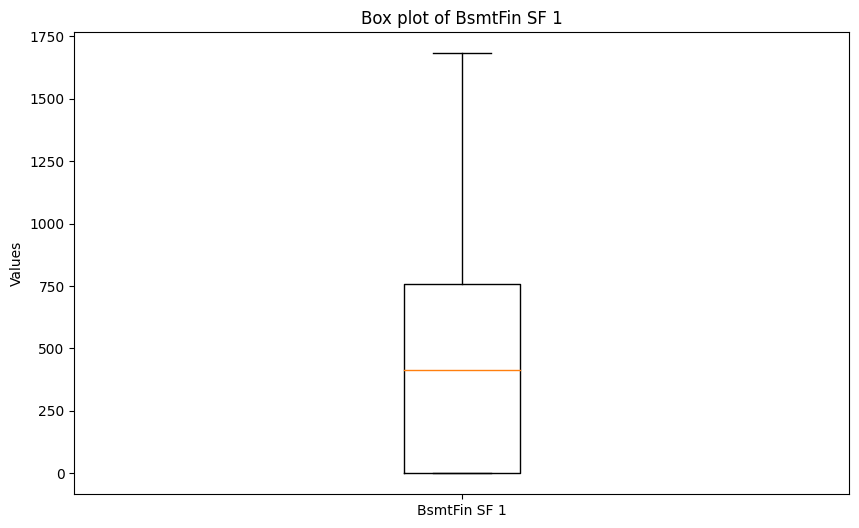

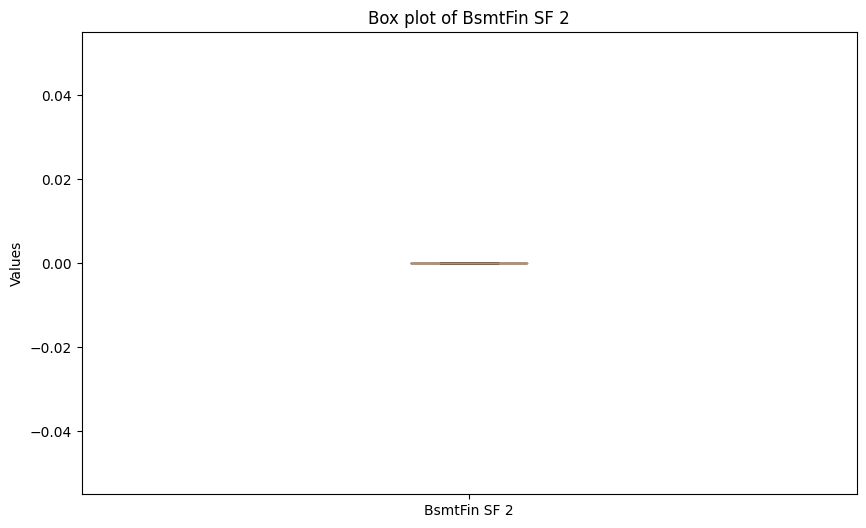

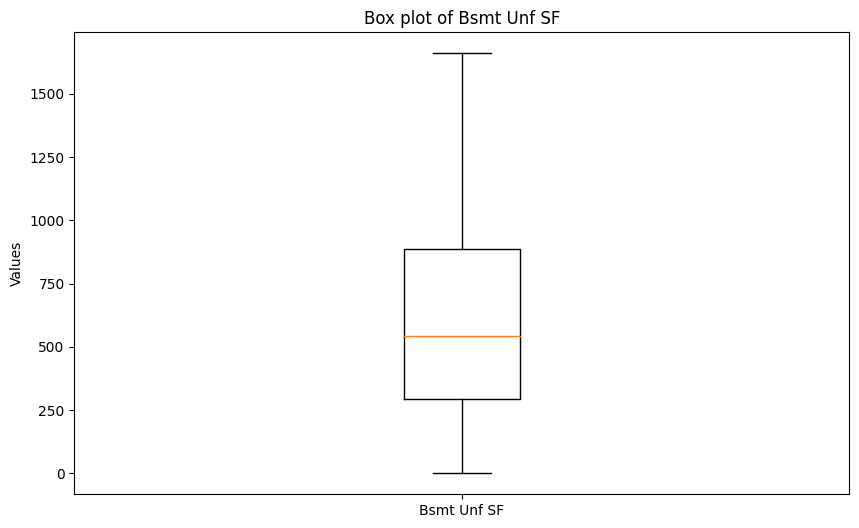

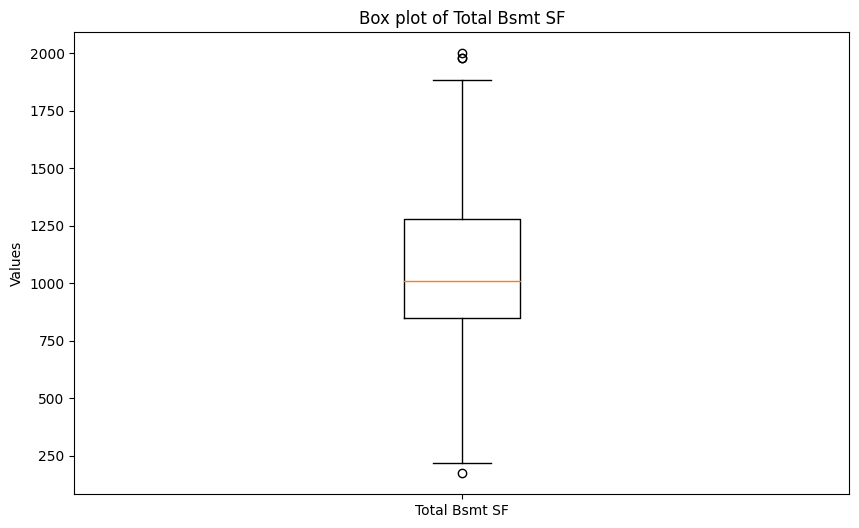

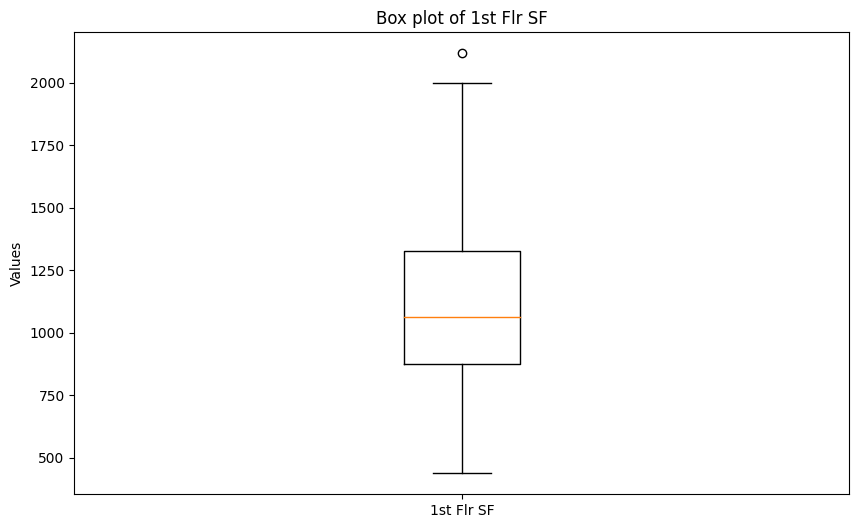

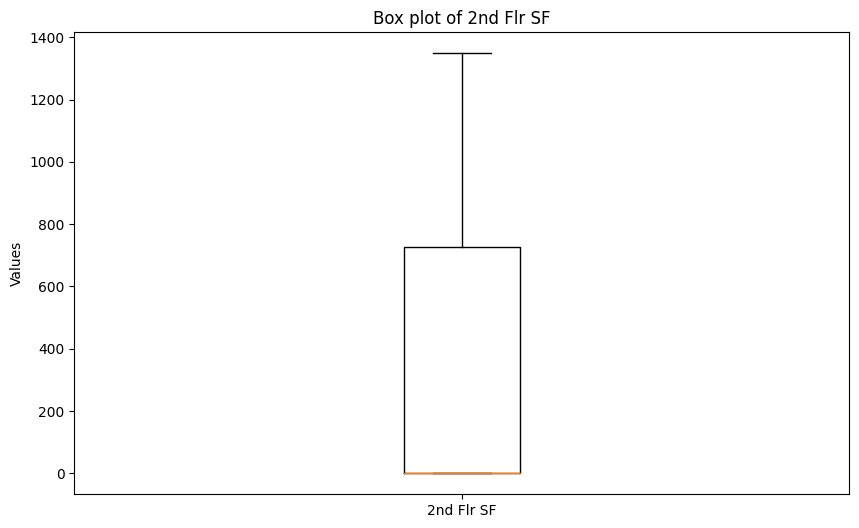

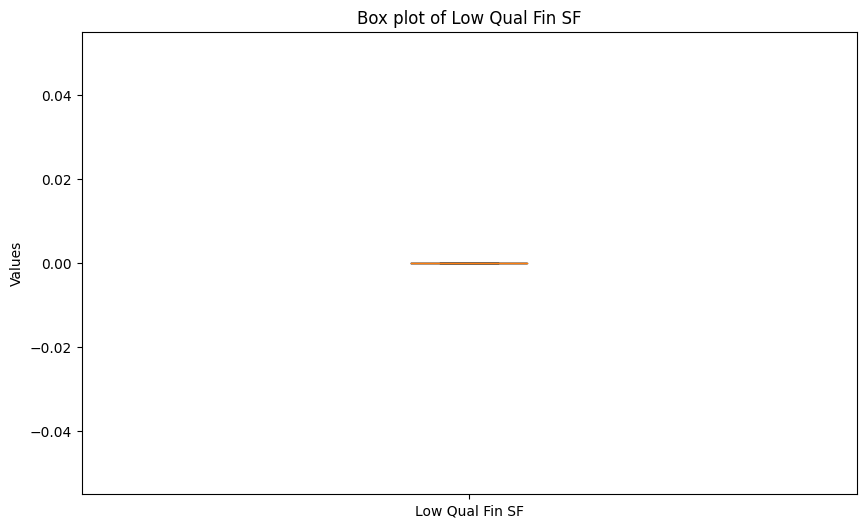

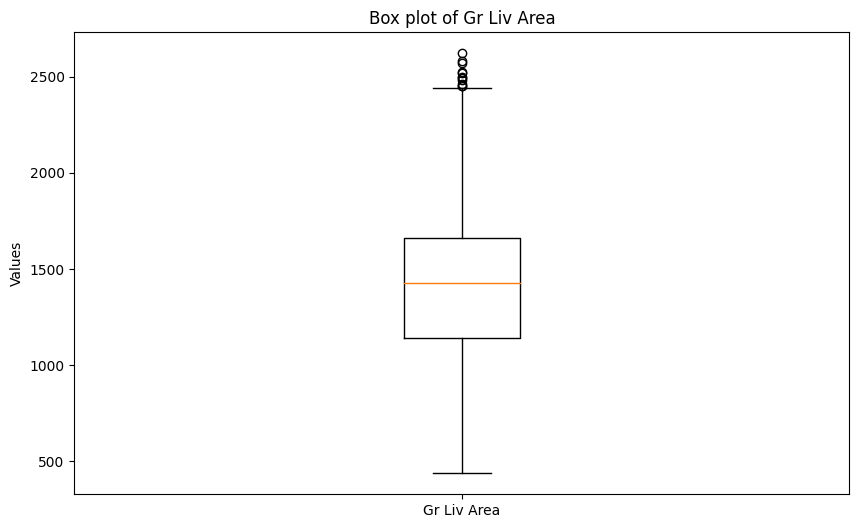

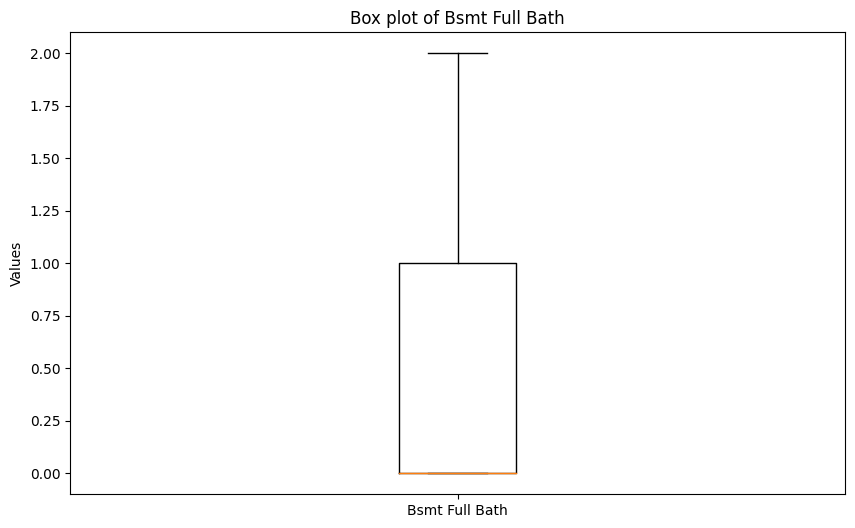

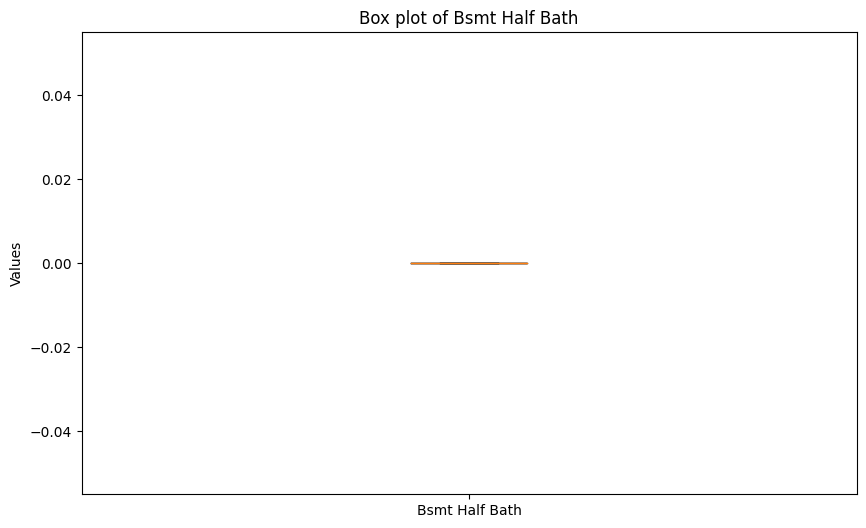

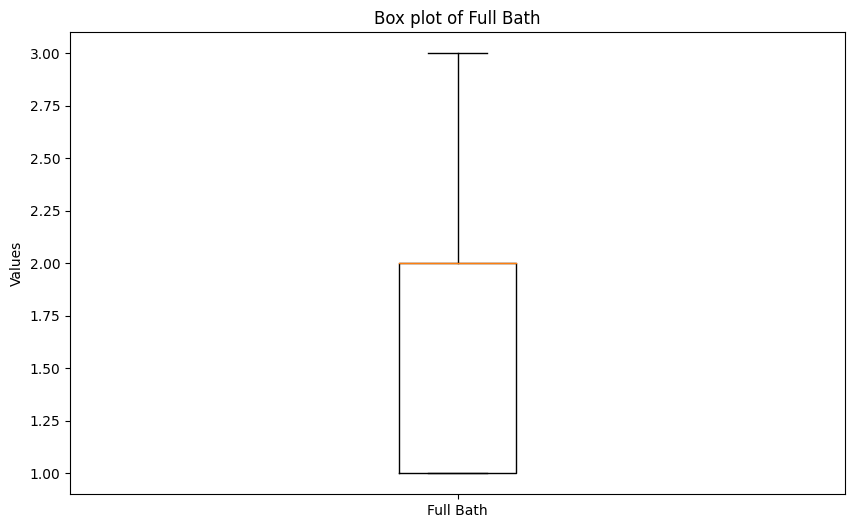

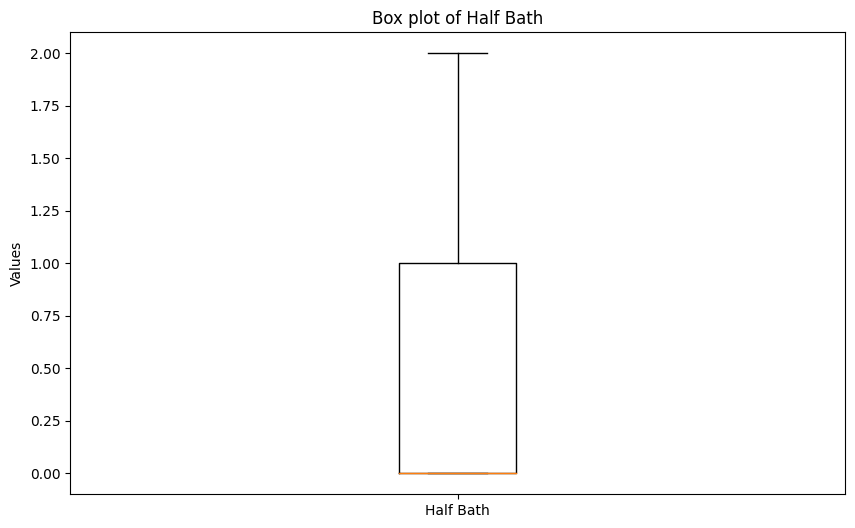

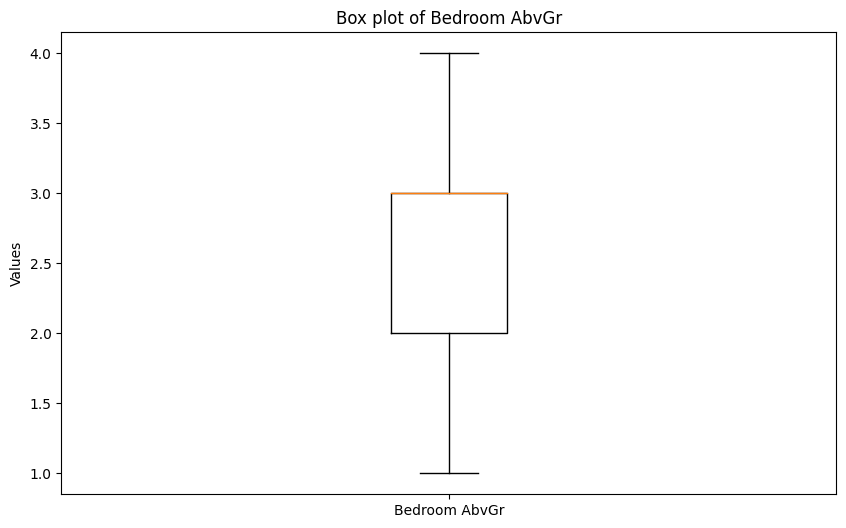

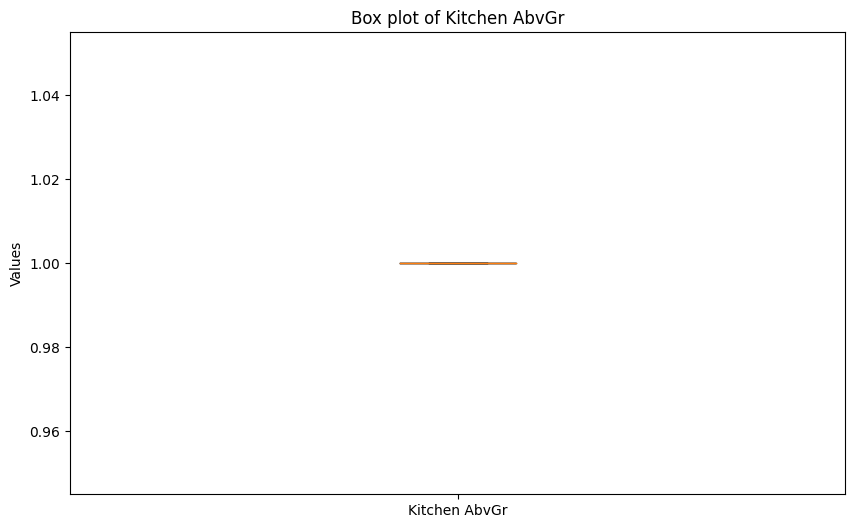

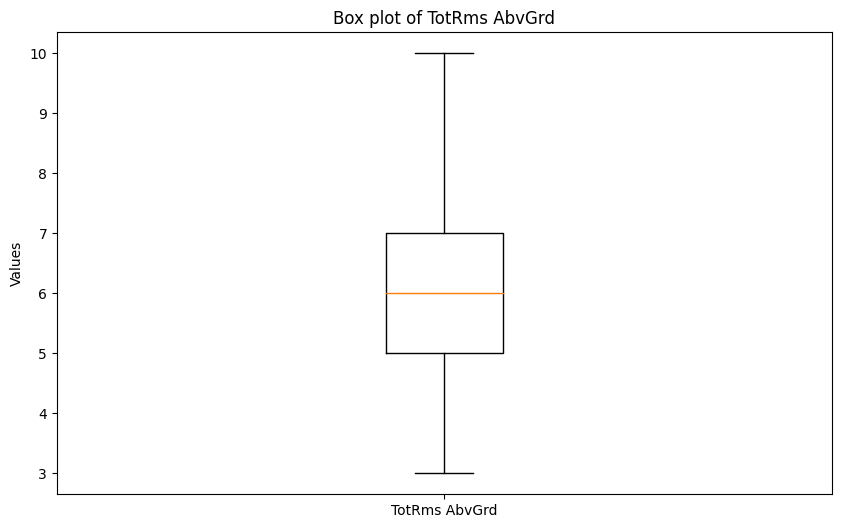

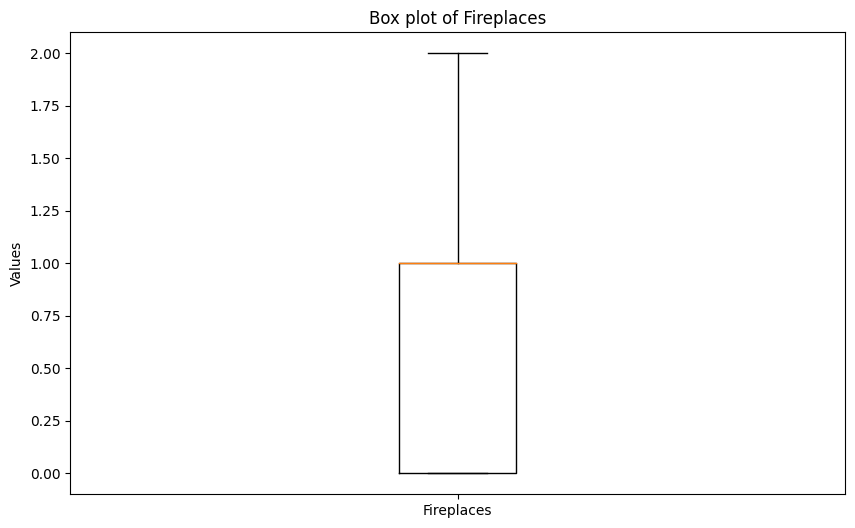

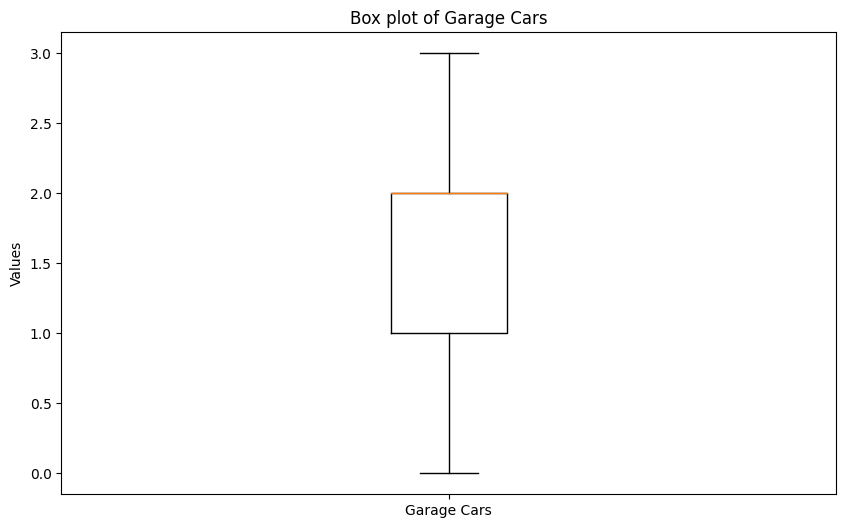

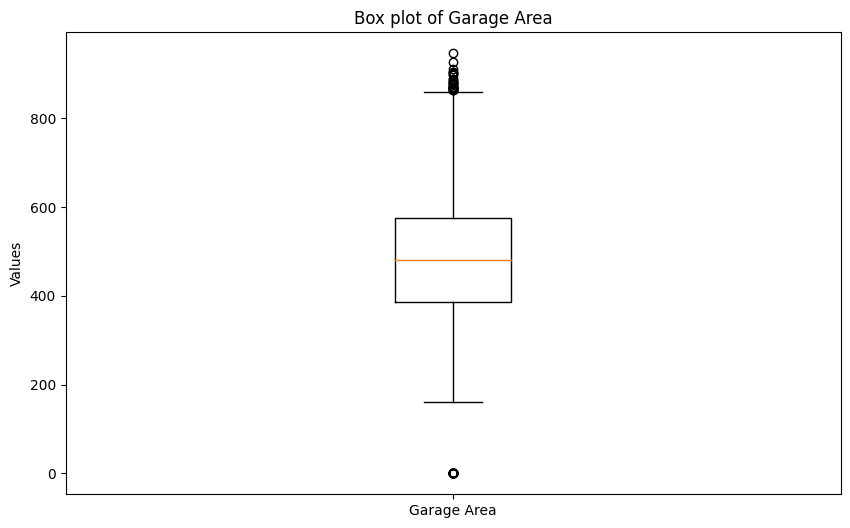

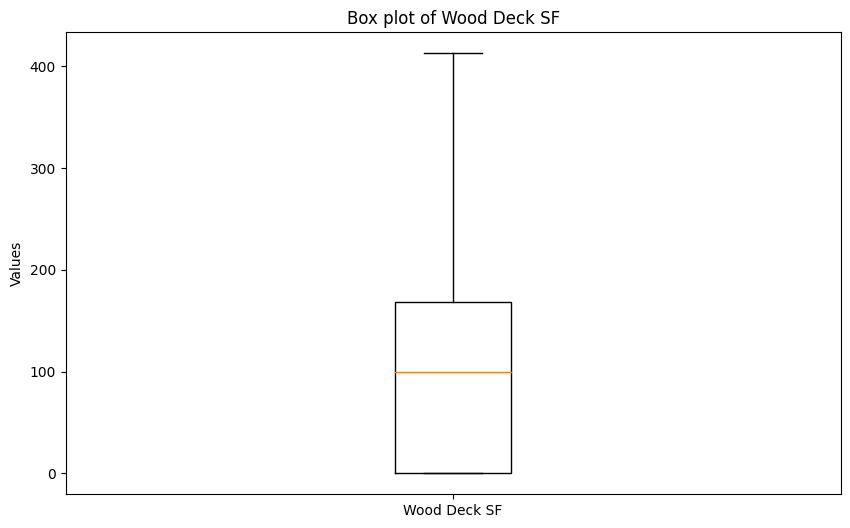

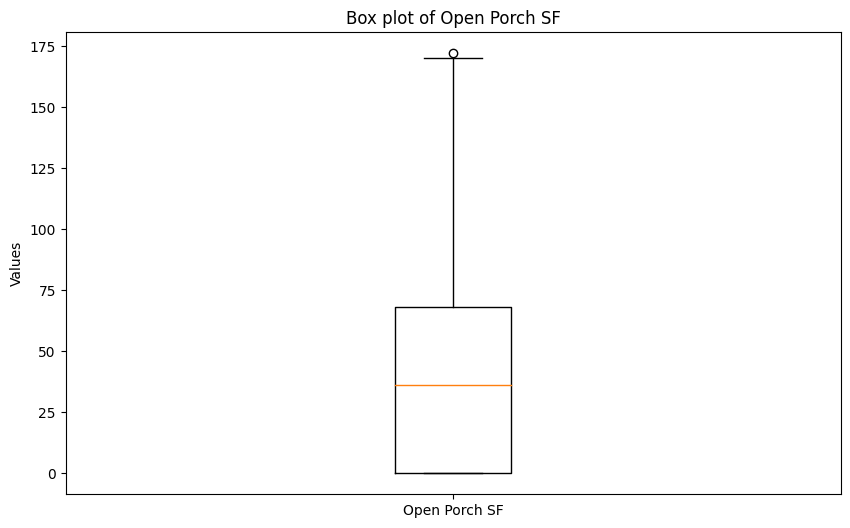

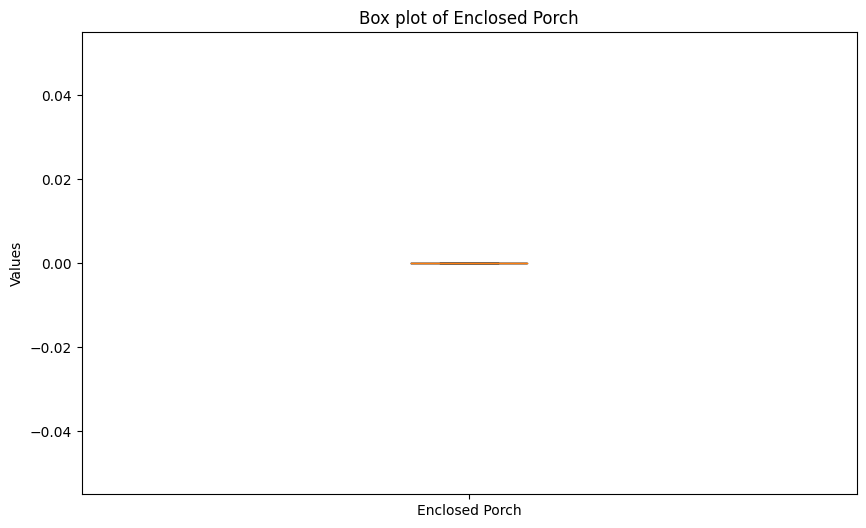

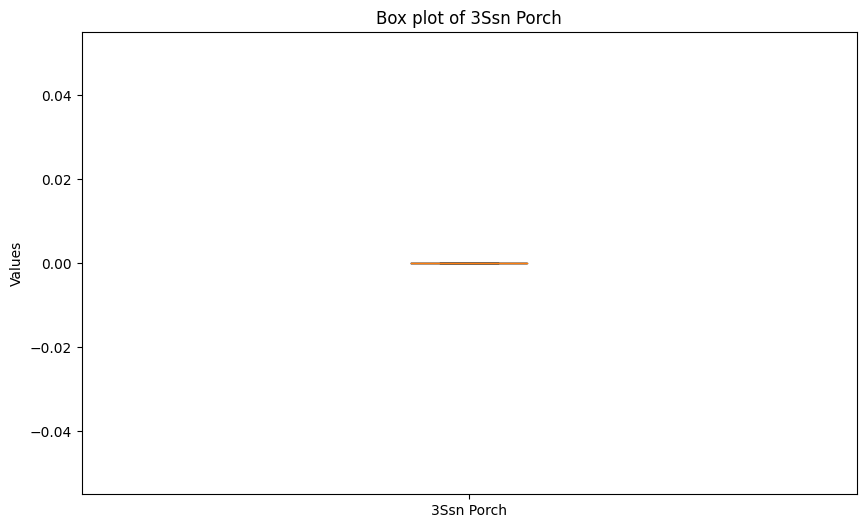

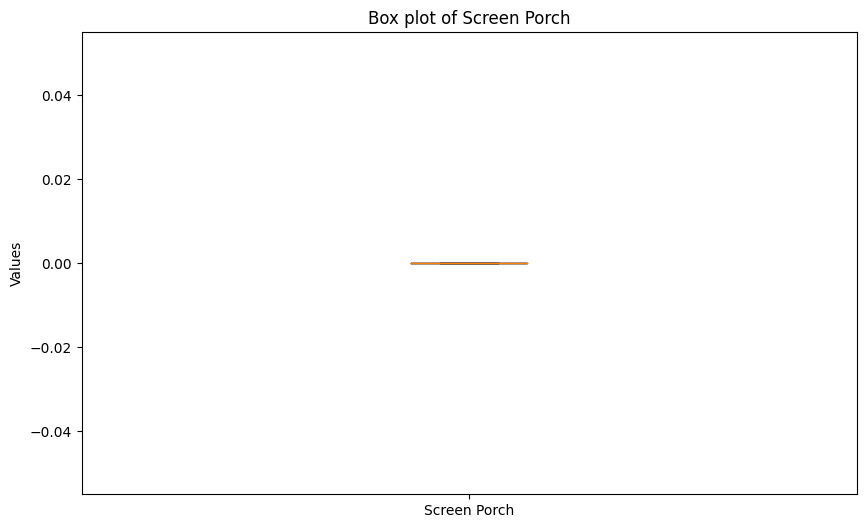

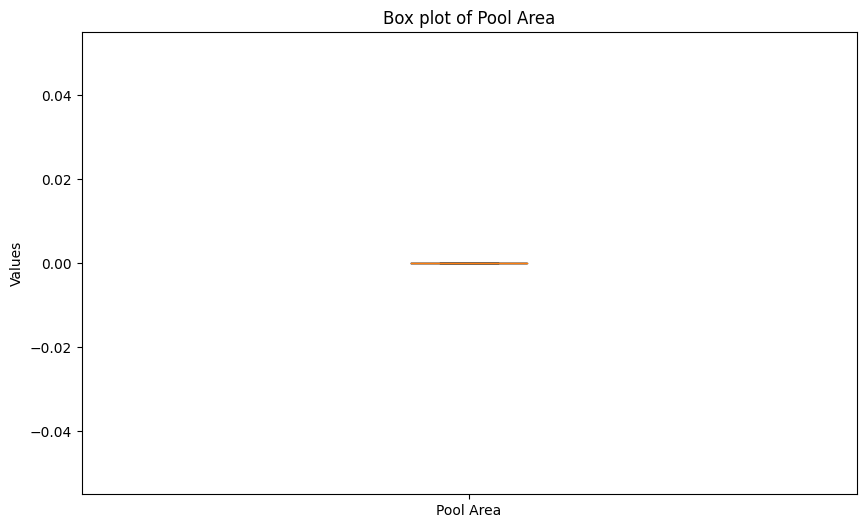

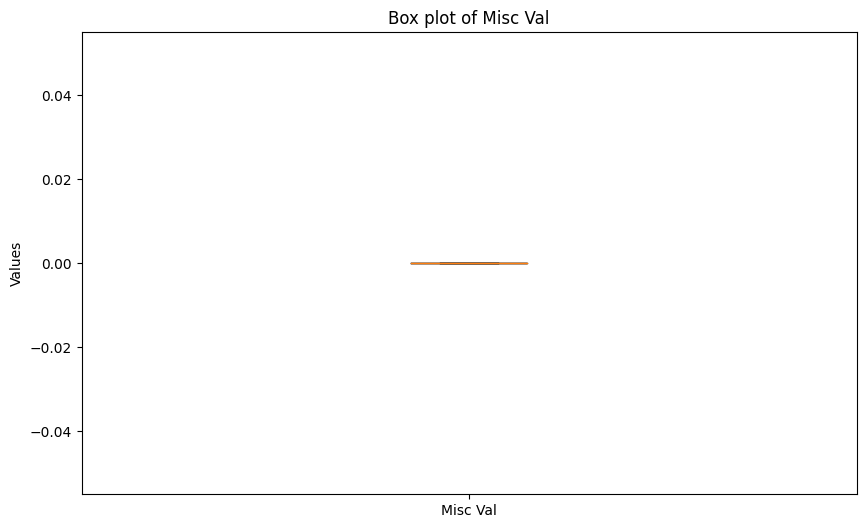

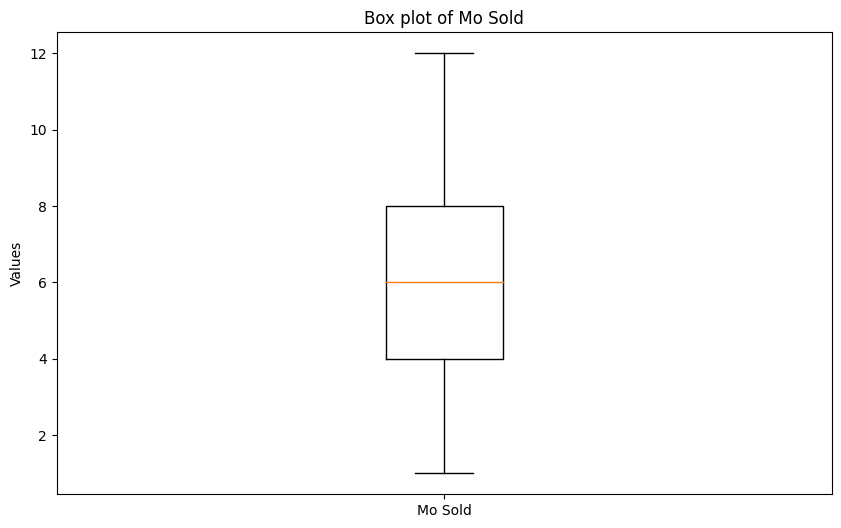

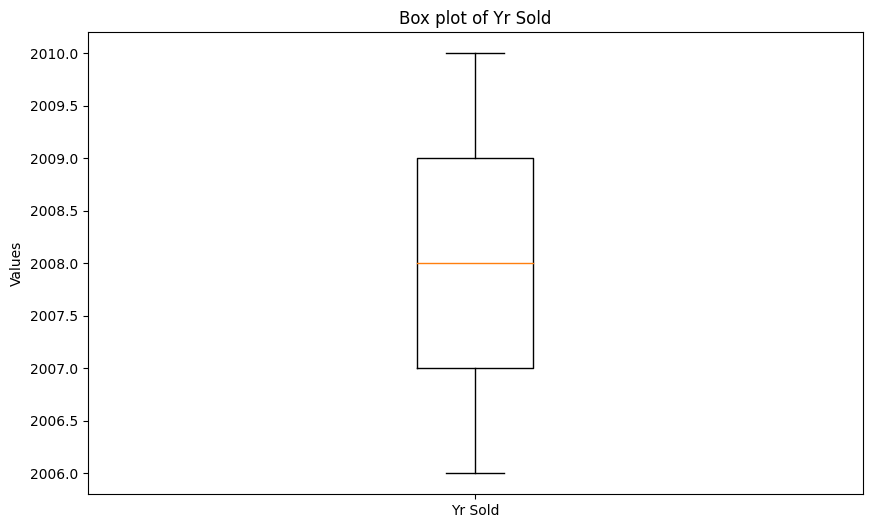

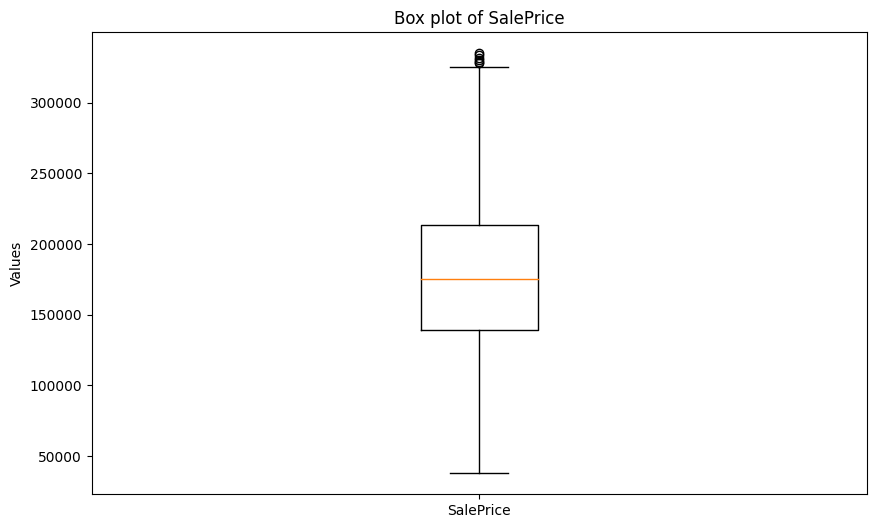

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation
# df = pd.DataFrame({
#     'feature_name': [...],  # Your data here
# })

# Creating a box plot
for i in filtered_df_numerical:
  plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
  plt.boxplot(filtered_df_numerical[i])
  plt.title(f'Box plot of {i}')
  plt.ylabel('Values')
  plt.xticks([1], [i])  # Adjust x-ticks if plotting multiple features

  plt.show()

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming df_numerical is your DataFrame with numerical features

# Preparing the data
X = df_numerical.drop(columns=['SalePrice'])  # Predictors
y = df_numerical['SalePrice']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.2, shuffle=True)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)  # Training the model

# Making predictions
y_pred = model.predict(X_test)

# Evaluation Metrics for Regression
mse = mean_squared_error(y_test, y_pred) # Mean Squared Error
print("\nMean Squared Error on Test Set:", mse)

# RSMPE
mse = np.sqrt(mean_squared_error(y_test, y_pred))  # Mean Squared Error
print("\nRoot Mean Squared Error on Test Set:", mse)

# MAE
mse = mean_absolute_error(y_test, y_pred)  # Mean Squared Error
print("\nMean Absolute Error on Test Set:", mse)


#rsmpe scores
rsmpe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
print("\nRoot Square Mean Percent Error on Test Set:", rsmpe)

# If you're interested in R² score (coefficient of determination)
r2_score = model.score(X_test, y_test)
print("\nR² Score on Test Set:", r2_score)

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer
# import numpy as np

# Define the RMSPE calculation function
def rmspe(y_true, y_pred):
    """Calculate Root Mean Square Percentage Error between true and predicted values"""
    # Ensure no division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    percentage_errors = ((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices]) ** 2
    return np.sqrt(np.mean(percentage_errors)) * 100

# Create a custom scorer. Scikit-learn's convention is to define a score where higher is better,
# so if you need "lower is better" like for an error metric, you should return the negative of the RMSPE.
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)



# Performing 10-fold cross-validation using MSE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring=rmspe_scorer)

# Convert scores to positive; cross_val_score returns negative values for MSE to maximize the score when using optimization algorithms
mse_scores = -scores


print()
print(f"Mean MSE across 10 folds: {mse_scores.mean()}")




Mean Squared Error on Test Set: 938655709.7109797

Root Mean Squared Error on Test Set: 30637.488632572018

Mean Absolute Error on Test Set: 20574.96872133087

Root Square Mean Percent Error on Test Set: 18.131097481797557

R² Score on Test Set: 0.8548298237238787

Mean MSE across 10 folds: 19.394644045875605


In [44]:
filter_drop = filtered_df_numerical.columns[filtered_df_numerical.nunique() == 1]
filtered_df_numerical.drop(columns = filter_drop,inplace = True )
filtered_df_numerical.nunique()

MS SubClass        10
Lot Area          783
Overall Qual        9
Overall Cond        4
Year Built         94
Year Remod/Add     61
Mas Vnr Area      216
BsmtFin SF 1      462
Bsmt Unf SF       658
Total Bsmt SF     549
1st Flr SF        571
2nd Flr SF        286
Gr Liv Area       625
Bsmt Full Bath      3
Full Bath           3
Half Bath           3
Bedroom AbvGr       4
TotRms AbvGrd       8
Fireplaces          3
Garage Cars         4
Garage Area       374
Wood Deck SF      187
Open Porch SF     129
Mo Sold            12
Yr Sold             5
SalePrice         535
dtype: int64

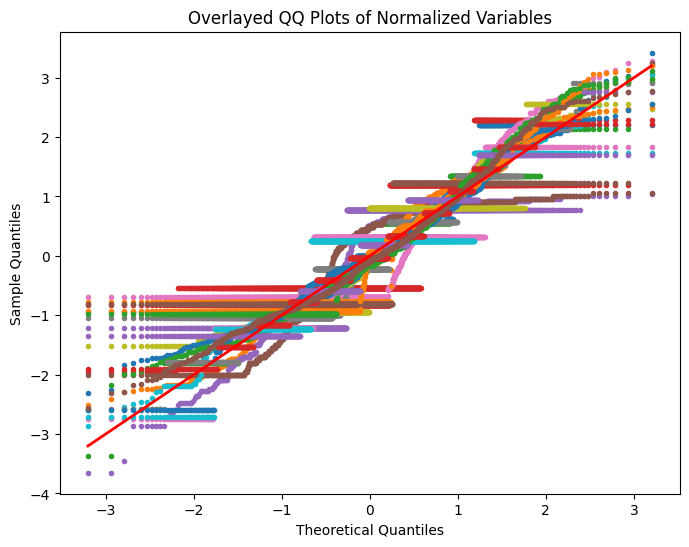

In [45]:
df_features = filtered_df_numerical
# Normalize each column in the DataFrame
normalized_df = (df_features - df_features.mean()) / df_features.std()

# Prepare the plot
plt.figure(figsize=(8, 6))

# Generate QQ plots for each normalized variable
for column in normalized_df:
    # Generate theoretical quantiles and sample quantiles
    (osm, osr), (slope, intercept, r) = stats.probplot(normalized_df[column], dist="norm")

    # Plot the sample quantiles against the theoretical quantiles
    plt.plot(osm, osr, marker='o', linestyle='', ms=3, label=column)

# Plot the line y = x, which represents a perfect match with the normal distribution
plt.plot([np.min(osm), np.max(osm)], [np.min(osm), np.max(osm)], 'r-', lw=2)

# plt.legend()
plt.title('Overlayed QQ Plots of Normalized Variables')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


In [ ]:
# Preparing the data
X = df_numerical.drop(columns=['SalePrice'])  # Predictors
y = df_numerical['SalePrice']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.2, shuffle=True)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)  # Training the model

# Making predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = model.score(X_test, y_test)  # R² Score

# Root Mean Square Percentage Error (RMSPE)
epsilon = 1e-8  # Avoid division by zero
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / (y_test + epsilon))))) * 100

# Performing 10-fold cross-validation using MSE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = -scores  # Convert scores to positive
mean_mse = mse_scores.mean()
mean_rmse = np.sqrt(-scores).mean()  # Average RMSE for cross-validation

# Define the RMSPE calculation function
def rmspe_func(y_true, y_pred):
    """Calculate Root Mean Square Percentage Error between true and predicted values"""
    # Ensure no division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    percentage_errors = ((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices]) ** 2
    return np.sqrt(np.mean(percentage_errors)) * 100

# Create a custom scorer. Scikit-learn's convention is to define a score where higher is better,
# so if you need "lower is better" like for an error metric, you should return the negative of the RMSPE.
rmspe_scorer = make_scorer(rmspe_func, greater_is_better=False)

# Performing 10-fold cross-validation using RMSPE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring=rmspe_scorer)

# Convert scores to positive; cross_val_score returns negative values for MSE to maximize the score when using optimization algorithms
rmspe_scores = -scores

# Displaying the metrics
print("\nEvaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Percentage Error (RMSPE): {rmspe}%")
print(f"R² Score: {r2}")


print("\nCross-validation Scores:")
print(f"Mean MSE across 10 folds: {mean_mse}")
print(f"Mean RMSE across 10 folds: {mean_rmse}")
print(f"Mean RMSPE across 10 folds: {rmspe_scores.mean()}")

#Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()


In [ ]:
# Preparing the data
X = filtered_df_numerical.drop(columns=['SalePrice'])  # Predictors
y = filtered_df_numerical['SalePrice']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.2, shuffle=True)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)  # Training the model

# Making predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = model.score(X_test, y_test)  # R² Score

# Root Mean Square Percentage Error (RMSPE)
epsilon = 1e-8  # Avoid division by zero
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / (y_test + epsilon))))) * 100

# Performing 10-fold cross-validation using MSE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = -scores  # Convert scores to positive
mean_mse = mse_scores.mean()
mean_rmse = np.sqrt(-scores).mean()  # Average RMSE for cross-validation

# Define the RMSPE calculation function
def rmspe_func(y_true, y_pred):
    """Calculate Root Mean Square Percentage Error between true and predicted values"""
    # Ensure no division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    percentage_errors = ((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices]) ** 2
    return np.sqrt(np.mean(percentage_errors)) * 100

# Create a custom scorer. Scikit-learn's convention is to define a score where higher is better,
# so if you need "lower is better" like for an error metric, you should return the negative of the RMSPE.
rmspe_scorer = make_scorer(rmspe_func, greater_is_better=False)

# Performing 10-fold cross-validation using RMSPE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring=rmspe_scorer)

# Convert scores to positive; cross_val_score returns negative values for MSE to maximize the score when using optimization algorithms
rmspe_scores = -scores

# Displaying the metrics
print("\nEvaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Percentage Error (RMSPE): {rmspe}%")
print(f"R² Score: {r2}")


print("\nCross-validation Scores:")
print(f"Mean MSE across 10 folds: {mean_mse}")
print(f"Mean RMSE across 10 folds: {mean_rmse}")
print(f"Mean RMSPE across 10 folds: {rmspe_scores.mean()}")

#Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()



In [48]:
filtered_df_numerical.shape

(1011, 26)


Evaluation Metrics on Test Set:
Mean Squared Error (MSE): 938652324.4665656
Root Mean Squared Error (RMSE): 30637.433385754844
Mean Absolute Error (MAE): 20573.87564935217
Root Mean Square Percentage Error (RMSPE): 18.131438632112115%
R² Score: 0.8548303472774279

Cross-validation Scores:
Mean MSE across 10 folds: 1073432237.1129797
Mean RMSE across 10 folds: 31811.774123942938
Mean RMSPE across 10 folds: 19.394392671220935


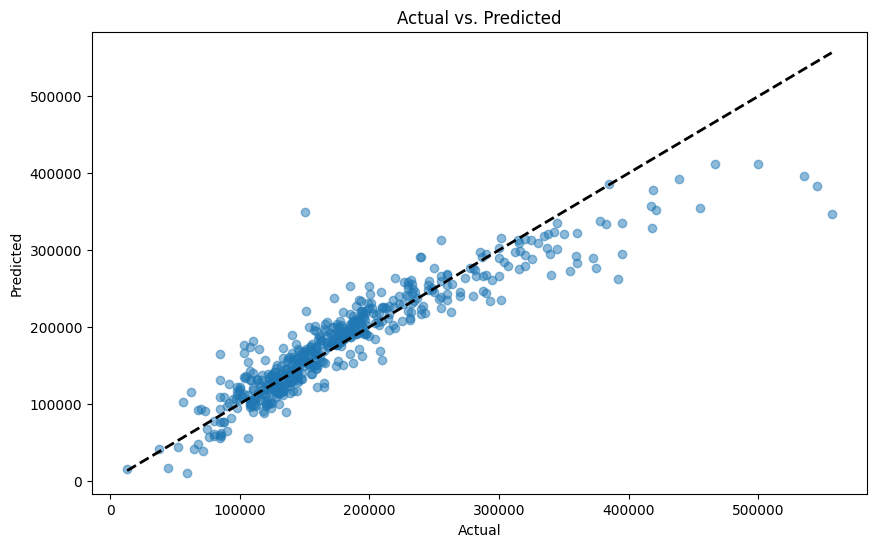

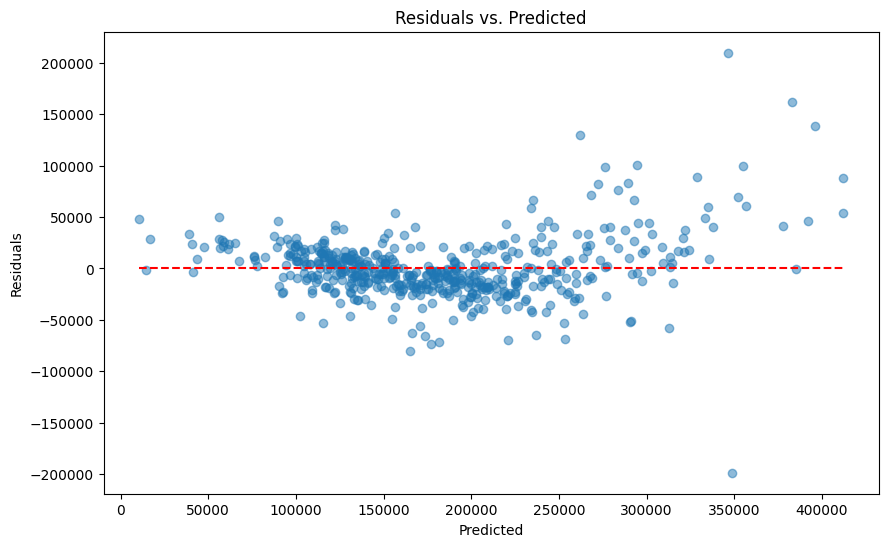

In [49]:
from sklearn.linear_model import LinearRegression, Lasso
# Preparing the data
X = df_numerical.drop(columns=['SalePrice'])  # Predictors
y = df_numerical['SalePrice']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.2, shuffle=True)

# Linear Regression Model
model = Lasso(alpha=1)
model.fit(X_train, y_train)  # Training the model

# Making predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = model.score(X_test, y_test)  # R² Score

# Root Mean Square Percentage Error (RMSPE)
epsilon = 1e-8  # Avoid division by zero
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / (y_test + epsilon))))) * 100

# Performing 10-fold cross-validation using MSE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = -scores  # Convert scores to positive
mean_mse = mse_scores.mean()
mean_rmse = np.sqrt(-scores).mean()  # Average RMSE for cross-validation

# Define the RMSPE calculation function
def rmspe_func(y_true, y_pred):
    """Calculate Root Mean Square Percentage Error between true and predicted values"""
    # Ensure no division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    percentage_errors = ((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices]) ** 2
    return np.sqrt(np.mean(percentage_errors)) * 100

# Create a custom scorer. Scikit-learn's convention is to define a score where higher is better,
# so if you need "lower is better" like for an error metric, you should return the negative of the RMSPE.
rmspe_scorer = make_scorer(rmspe_func, greater_is_better=False)

# Performing 10-fold cross-validation using RMSPE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring=rmspe_scorer)

# Convert scores to positive; cross_val_score returns negative values for MSE to maximize the score when using optimization algorithms
rmspe_scores = -scores

# Displaying the metrics
print("\nEvaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Percentage Error (RMSPE): {rmspe}%")
print(f"R² Score: {r2}")


print("\nCross-validation Scores:")
print(f"Mean MSE across 10 folds: {mean_mse}")
print(f"Mean RMSE across 10 folds: {mean_rmse}")
print(f"Mean RMSPE across 10 folds: {rmspe_scores.mean()}")

#Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()



Evaluation Metrics on Test Set:
Mean Squared Error (MSE): 938693811.767877
Root Mean Squared Error (RMSE): 30638.110447086598
Mean Absolute Error (MAE): 20572.73622384486
Root Mean Square Percentage Error (RMSPE): 18.13151859166319%
R² Score: 0.8548239309537617

Cross-validation Scores:
Mean MSE across 10 folds: 1073402460.0375154
Mean RMSE across 10 folds: 31810.996072305083
Mean RMSPE across 10 folds: 19.39270284785408


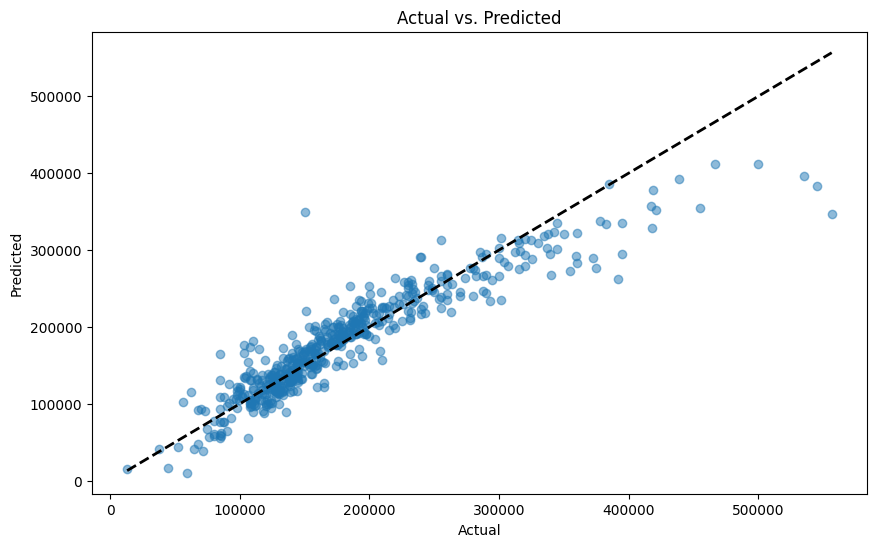

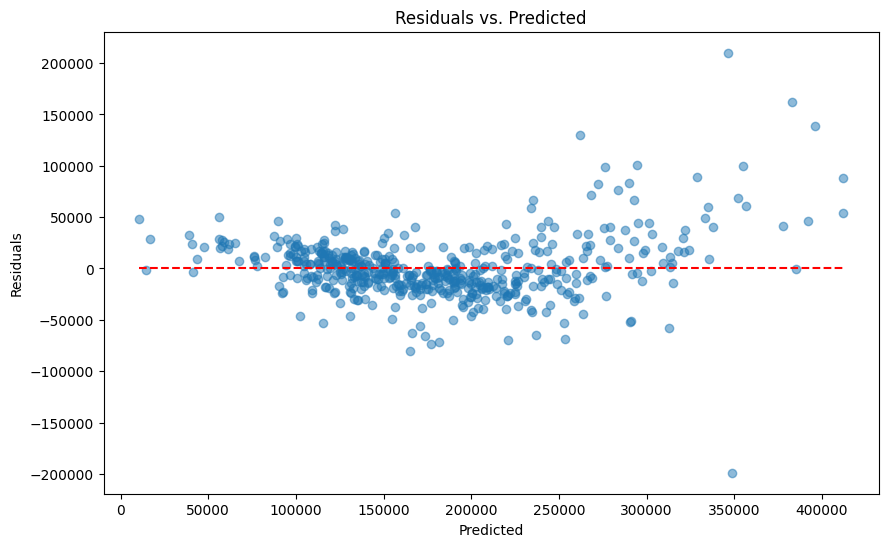

In [50]:
from sklearn.linear_model import LinearRegression, Ridge
# Preparing the data
X = df_numerical.drop(columns=['SalePrice'])  # Predictors
y = df_numerical['SalePrice']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.2, shuffle=True)

# Linear Regression Model
model = Ridge()
model.fit(X_train, y_train)  # Training the model

# Making predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = model.score(X_test, y_test)  # R² Score

# Root Mean Square Percentage Error (RMSPE)
epsilon = 1e-8  # Avoid division by zero
rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / (y_test + epsilon))))) * 100

# Performing 10-fold cross-validation using MSE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = -scores  # Convert scores to positive
mean_mse = mse_scores.mean()
mean_rmse = np.sqrt(-scores).mean()  # Average RMSE for cross-validation

# Define the RMSPE calculation function
def rmspe_func(y_true, y_pred):
    """Calculate Root Mean Square Percentage Error between true and predicted values"""
    # Ensure no division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    percentage_errors = ((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices]) ** 2
    return np.sqrt(np.mean(percentage_errors)) * 100

# Create a custom scorer. Scikit-learn's convention is to define a score where higher is better,
# so if you need "lower is better" like for an error metric, you should return the negative of the RMSPE.
rmspe_scorer = make_scorer(rmspe_func, greater_is_better=False)

# Performing 10-fold cross-validation using RMSPE as the scoring metric
scores = cross_val_score(model, X, y, cv=10, scoring=rmspe_scorer)

# Convert scores to positive; cross_val_score returns negative values for MSE to maximize the score when using optimization algorithms
rmspe_scores = -scores

# Displaying the metrics
print("\nEvaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Percentage Error (RMSPE): {rmspe}%")
print(f"R² Score: {r2}")


print("\nCross-validation Scores:")
print(f"Mean MSE across 10 folds: {mean_mse}")
print(f"Mean RMSE across 10 folds: {mean_rmse}")
print(f"Mean RMSPE across 10 folds: {rmspe_scores.mean()}")

#Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()


## Data Processing

10. Create two data frames: one with all the predictor columns (everything except for Unnamed: 0, ID_code and target) and one with just the target. Make sure they are copies and not slices.

1. Define a Gaussian Naïve Bayes model using Sklearn.

1. Divide the two data frames you created in step #10 into training and testing subsets.

1. Train the model using the training subset of the dataset.

1. Test the model using the testing subset of the dataset. Calculate and report the accuracy.

1. Perform a cross-validation loop to calculate the accuracy of your model. Report that accuracy. How does it compare to the accuracy you calculated in #14?

1. Plot a histogram of the accuracy scores you generated in your cross-validation loop. What do you notice about the distribution of accuracy scores?

1.  Present the confusion matrix and the results of your Classification Report (sklearn.metrics.classification_report). What do you notice?

1. The training data is very skewed towards non-successful transactions (about 90% of the training data has ‘target’==0). Remove enough non-successful transaction rows so that your remaining training data is 50%/50% split between successful and non-successful transactions. Hint: you can use the data frames you created in step #9.

1. Repeat the cross-validation process on this data set. Report what your cross-validation accuracy is in this 50/50 case.



## Data Visualization


20. Compare the results of your cross-validation with the whole training data and the reduced 50/50 training data

1. Present the confusion matrix and the results of your Classification Report (sklearn.metrics.classification_report)




## Communicate the Results

22. Communicate the results of your analysis.



## Submit Final Project

23. Upload your finished Jupyter notebook to your Project 1 student folder.
